# Datathon Cajamar UniversityHack 2022 - Cajamar Water Footprint

## Script Exploración - Equipo DPNA

- Pablo Torrijos Arenas
- Mykola Mandzyak Melnyk
- Alejandro Gómez Escribano

## Imports y leer csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')    # Gráficos de mejor calidad

pd.options.display.max_info_rows = 30000000

sns.set_style('darkgrid')

# Tamaño figuras
plt.rcParams["figure.figsize"] = (15,6)

C:\Users\pablo\AppData\Local\Temp/ipykernel_15436/292236840.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')    # Gráficos de mejor calidad


In [46]:
df = pd.read_csv('data/Modelar_UH2022.txt', sep='|', index_col='ID', parse_dates=True)
df.head()

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
0,2019-06-13 08:34:09,369320,0.0,17,0.0
0,2019-06-13 17:34:10,369403,0.0,2,0.0
0,2019-06-13 18:34:10,369403,0.0,0,0.0
0,2019-06-13 04:34:10,369284,0.0,1,0.0
0,2019-06-13 14:34:10,369356,0.0,28,0.0


Tenemos 2747 contadores:

In [47]:
df.index.drop_duplicates()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2739, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2756],
           dtype='int64', name='ID', length=2747)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21404828 entries, 0 to 2756
Data columns (total 5 columns):
 #   Column             Non-Null Count     Dtype  
---  ------             --------------     -----  
 0   SAMPLETIME         21404828 non-null  object 
 1   READINGINTEGER     21404828 non-null  int64  
 2   READINGTHOUSANDTH  21264772 non-null  float64
 3   DELTAINTEGER       21404828 non-null  int64  
 4   DELTATHOUSANDTH    21264772 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1012.1+ MB


La variable SAMPLETIME la lee como `object`, vamos a convertirla a `datetime64[ns]`:

In [49]:
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21404828 entries, 0 to 2756
Data columns (total 5 columns):
 #   Column             Non-Null Count     Dtype         
---  ------             --------------     -----         
 0   SAMPLETIME         21404828 non-null  datetime64[ns]
 1   READINGINTEGER     21404828 non-null  int64         
 2   READINGTHOUSANDTH  21264772 non-null  float64       
 3   DELTAINTEGER       21404828 non-null  int64         
 4   DELTATHOUSANDTH    21264772 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1012.1 MB


In [51]:
df.describe()

,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,2.140483e+07,2.126477e+07,2.140483e+07,2.126477e+07
mean,6.052178e+05,3.930737e+00,2.277017e+01,4.228367e+00
std,2.857464e+06,1.496893e+01,1.516794e+03,1.541059e+01
min,-6.407800e+04,0.000000e+00,-5.307340e+05,0.000000e+00
25%,6.368800e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.831570e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.520500e+05,0.000000e+00,9.000000e+00,0.000000e+00
max,5.108976e+07,9.900000e+01,9.499810e+05,9.900000e+01


## ¿Valores perdidos?

Uno de los primeros pasos que tenemos que realizar es comprobar si en los datos contamos con valores perdidos y, de ser así, en qué variables se encuentran

### Visualización

Hay muchos contadores a los que les faltan datos. De hecho algunos solo tienen 4 entradas. También hay 4 con más entradas de las que deberían (8759) (aunque debería ser 8760)

In [52]:
df.groupby(['ID']).size().sort_values()

ID
2756        4
2747        4
2744        4
2743        4
2732        5
        ...  
998      8759
248     34956
1416    34970
292     35054
545     35076
Length: 2747, dtype: int64

Aún así, la mayoría de los contadores tienen todos los valores que deberían:

<AxesSubplot:ylabel='Count'>

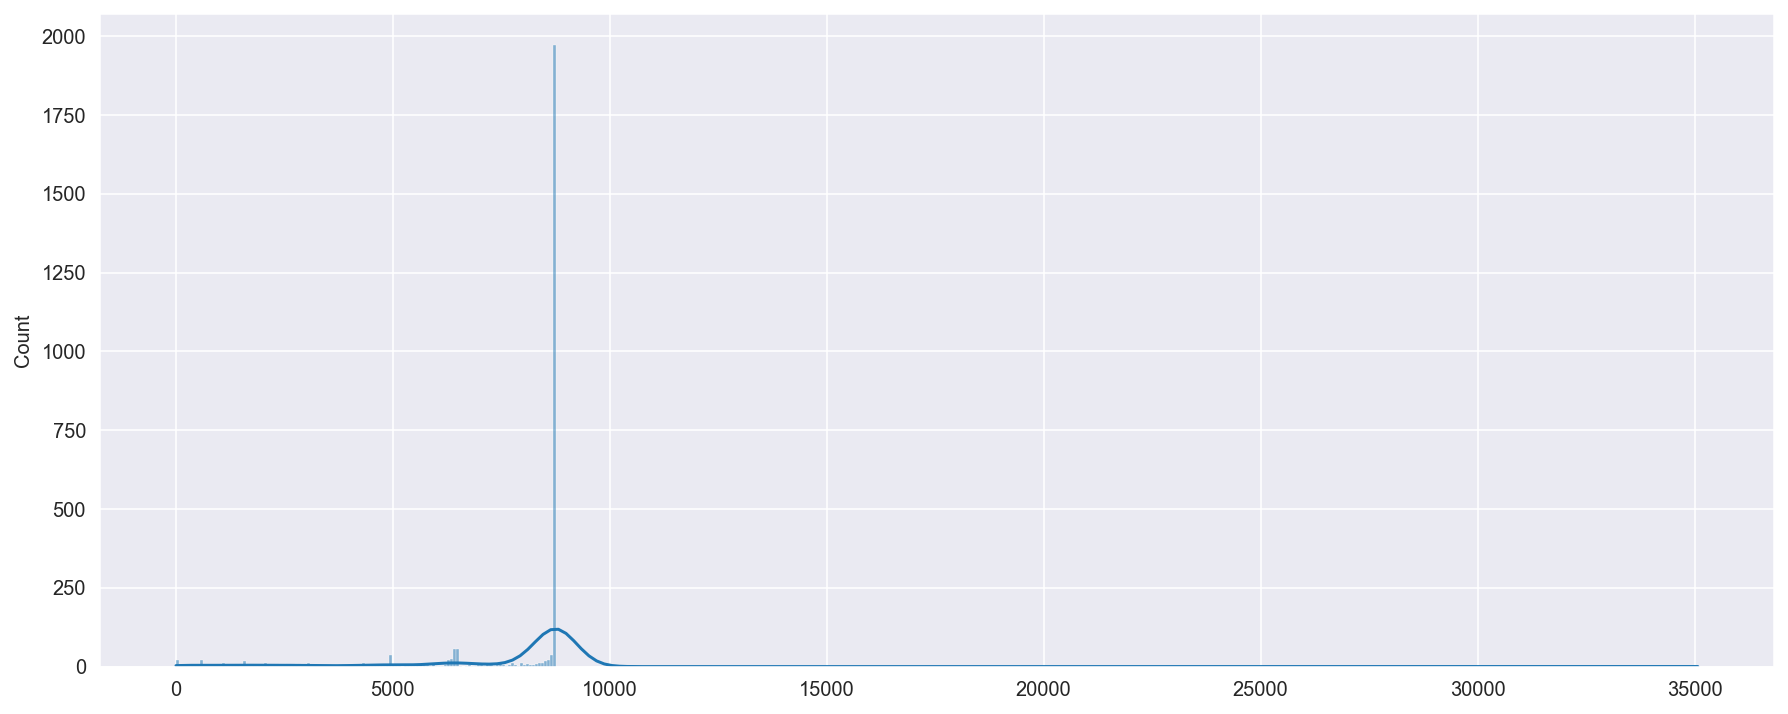

In [53]:
sns.histplot(df.groupby(['ID']).size().sort_values(), bins=500, kde=True)

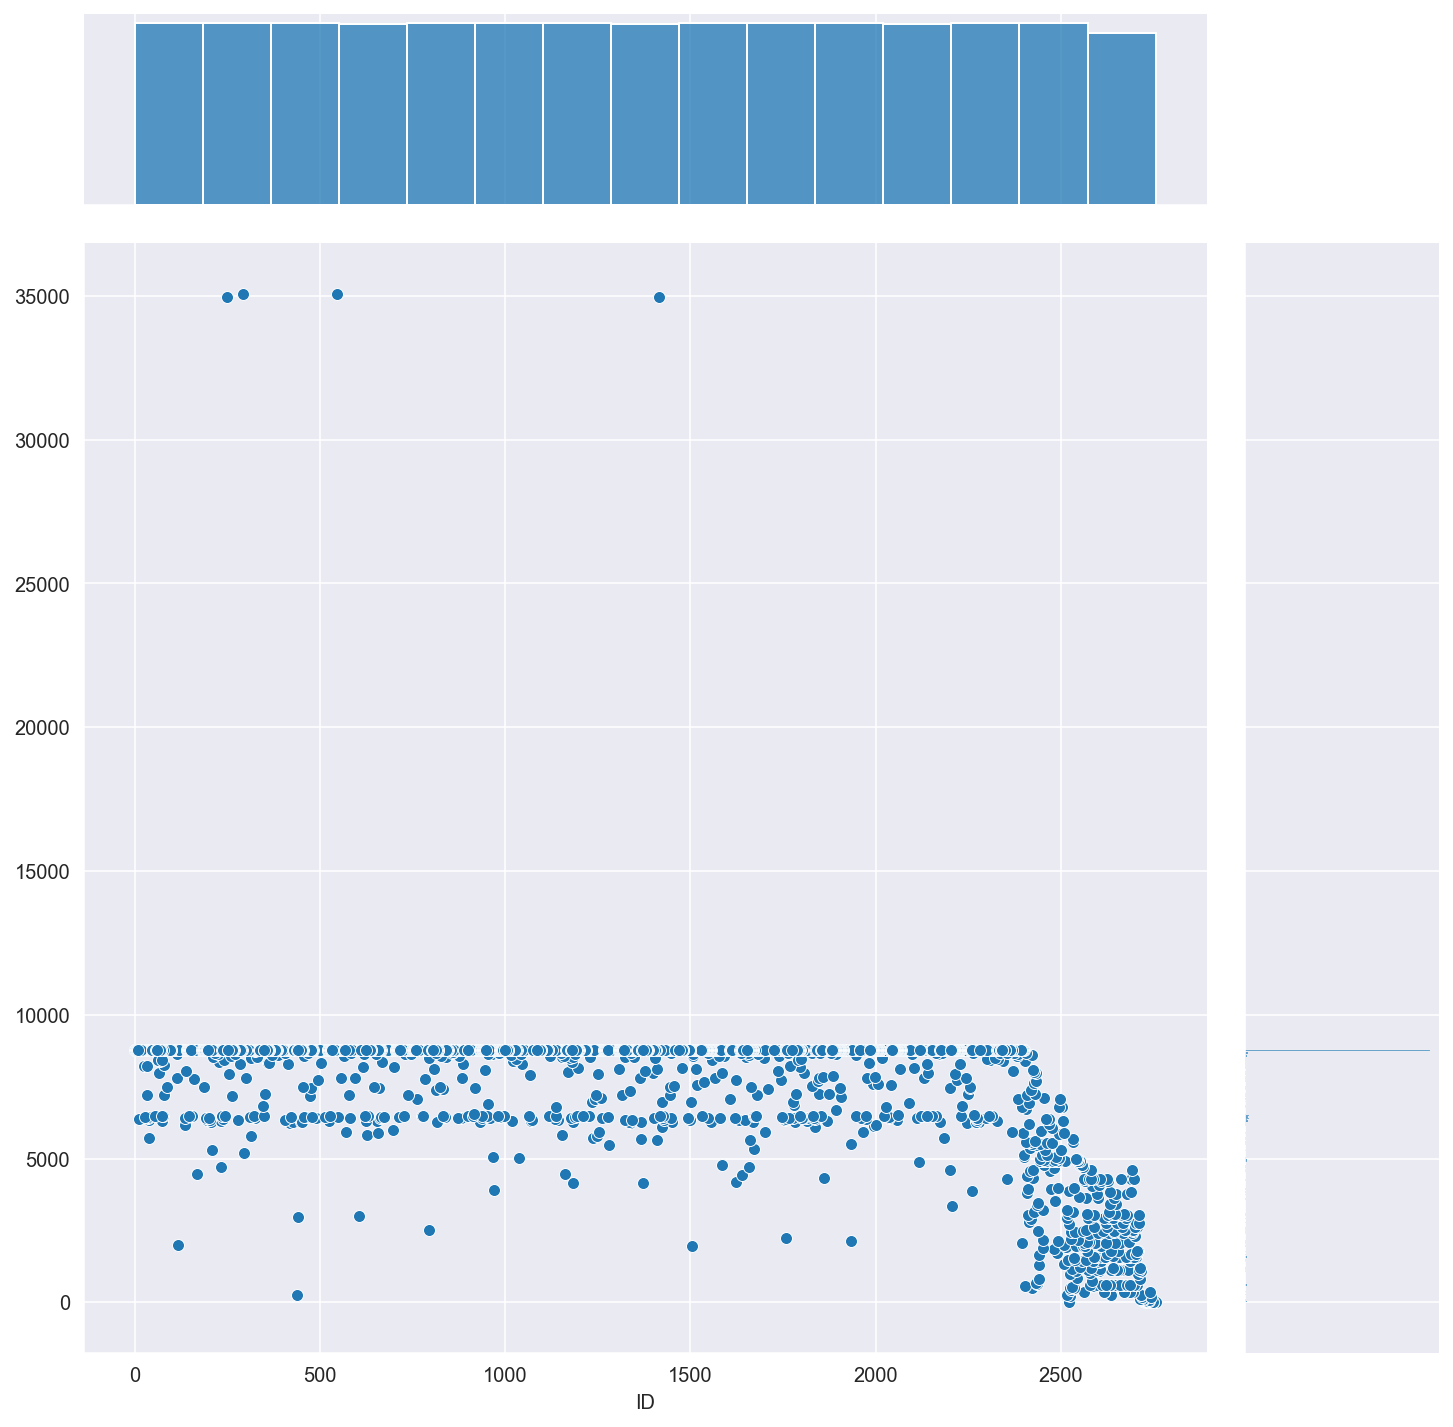

In [55]:
sns.jointplot(data=df.groupby(['ID']).size().sort_values(), kind='scatter', height=10)

La bajada de registros a partir del ID +- 2400 puede ser porque sean los últimos que se han añadido y no tengan registros desde el principio. Se puede ver mejor si no representamos los 4 ID con más datos:

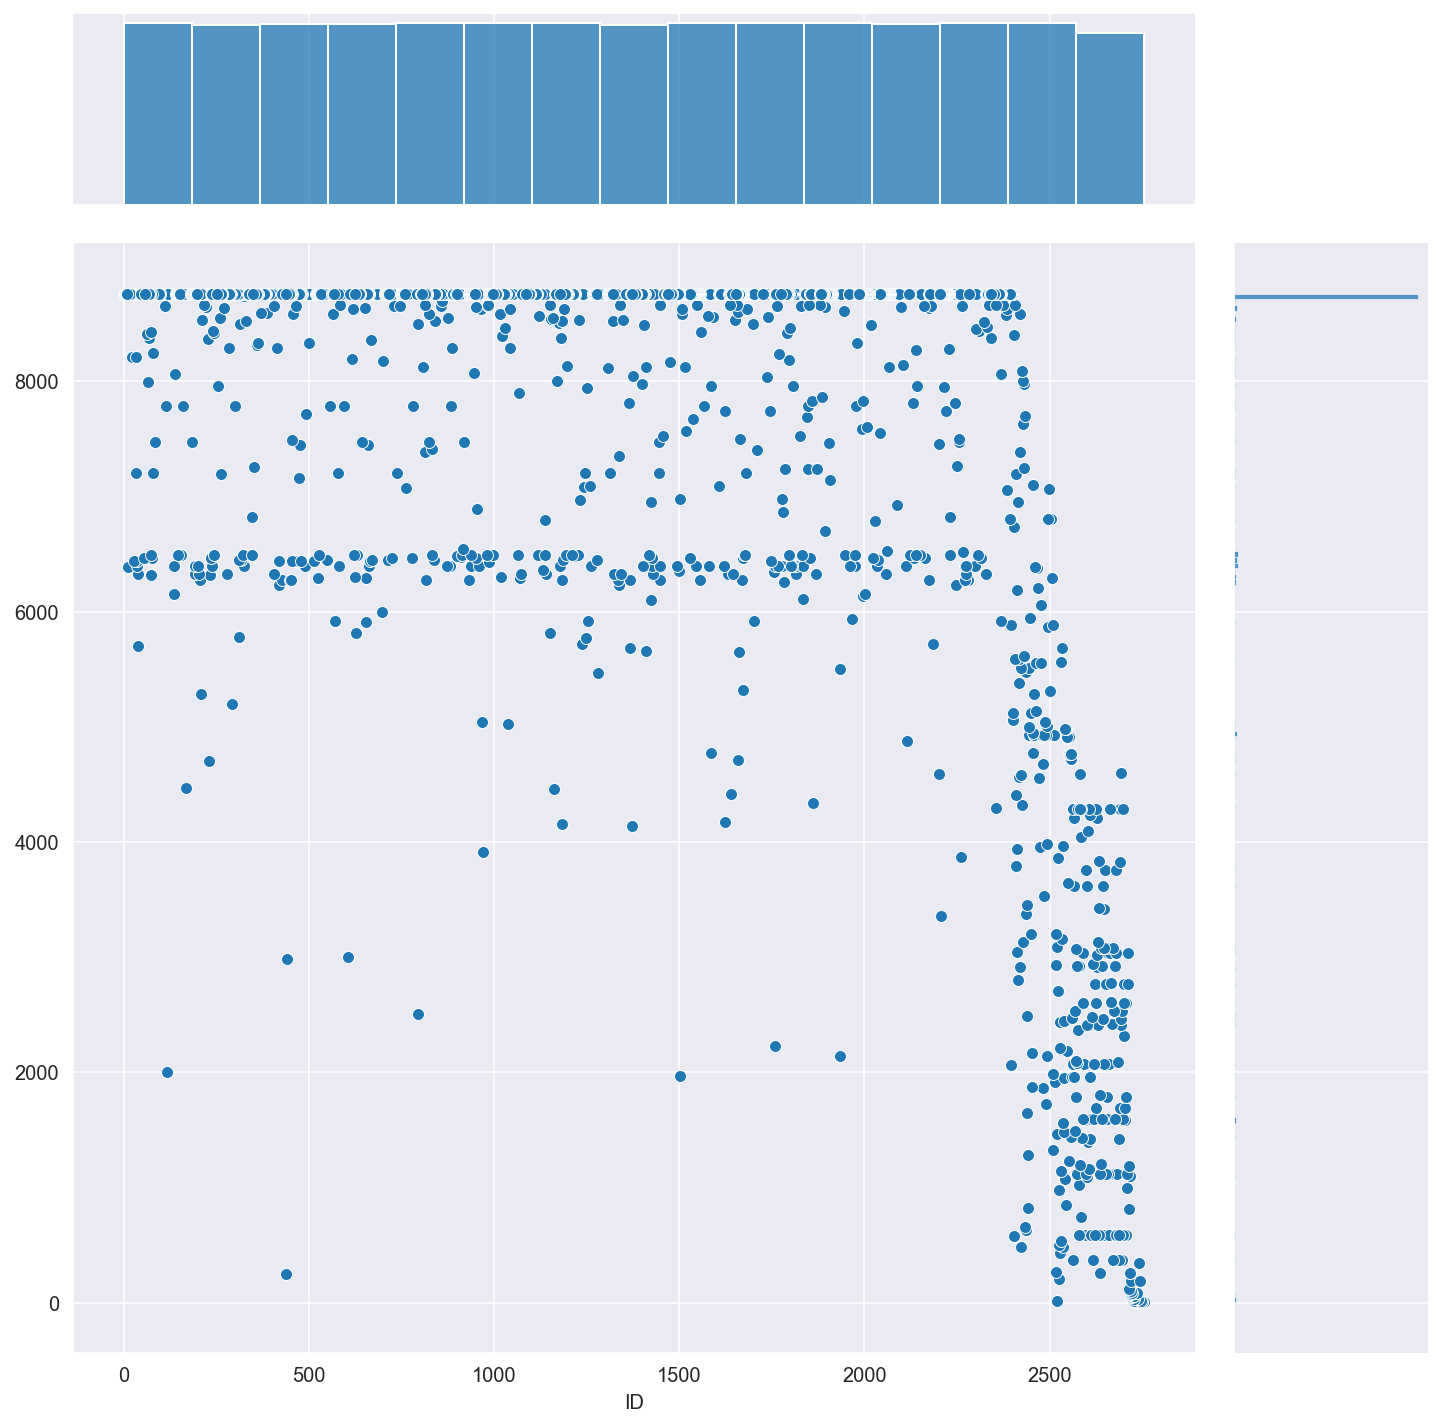

In [56]:
sns.jointplot(data=df.groupby(['ID']).size().sort_values()[:2743], kind='scatter', height=10)

In [57]:
df.groupby(['ID']).size().describe()

count     2747.000000
mean      7792.074263
std       2370.917299
min          4.000000
25%       8421.000000
50%       8759.000000
75%       8759.000000
max      35076.000000
dtype: float64

Parece que los contadores que leen más (ID 248, 1416, 292, 545) es porque lo hacen cada 15 minutos. Además tienen NaN en la parte decimal

In [58]:
df.loc[248]

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
248,2019-06-13 18:30:00,26752630,NaN,0,NaN
248,2019-06-13 04:30:00,26676570,NaN,3290,NaN
248,2019-06-13 16:30:00,26752630,NaN,0,NaN
248,2019-06-13 18:45:00,26752630,NaN,0,NaN
248,2019-06-13 09:45:00,26736300,NaN,2780,NaN
...,...,...,...,...,...
248,2020-01-25 09:30:00,35367090,NaN,0,NaN
248,2020-01-25 16:00:00,35367090,NaN,0,NaN
248,2020-01-25 11:00:00,35367090,NaN,0,NaN


#### Comprobar para qué meses hay menos valores

2747 ID * 24 horas = 65.928 horas al día

Enero, Marzo, Mayo, Julio, Agosto, Octubre, Diciembre: 31 * 65.928 = 2.043.768 horas

Abril, Junio, Septiembre, Noviembre: 30 * 65.928 = 1.977.840 horas

Febrero: 28 * 65.928 = 1.845.984 horas

In [60]:
df2 = df.groupby(df.SAMPLETIME.dt.to_period('M')).agg("count")["SAMPLETIME"].to_frame()
s = pd.Series(12*['SAMPLETIME'])
df2['Tipo'] = s.values

df3 = df.groupby(df.SAMPLETIME.dt.to_period('M')).agg("count")["SAMPLETIME"].to_frame()
s = pd.Series([1845984,2043768,1977840,2043768,1977840,2043768,2043768,1977840,2043768,1977840,2043768,2043768])
df3['SAMPLETIME'] = s.values
s = pd.Series(12*["ESPERADO"])
df3['Tipo'] = s.values

df2 = pd.concat([df2, df3])
df2["Mes"] = df2.index
df2

,SAMPLETIME,Tipo,Mes
SAMPLETIME,,,
2019-02,1522985,SAMPLETIME,2019-02
2019-03,1701944,SAMPLETIME,2019-03
2019-04,1668736,SAMPLETIME,2019-04
2019-05,1771551,SAMPLETIME,2019-05
2019-06,1729785,SAMPLETIME,2019-06
2019-07,1802685,SAMPLETIME,2019-07
2019-08,1832859,SAMPLETIME,2019-08
2019-09,1760192,SAMPLETIME,2019-09
2019-10,1871522,SAMPLETIME,2019-10


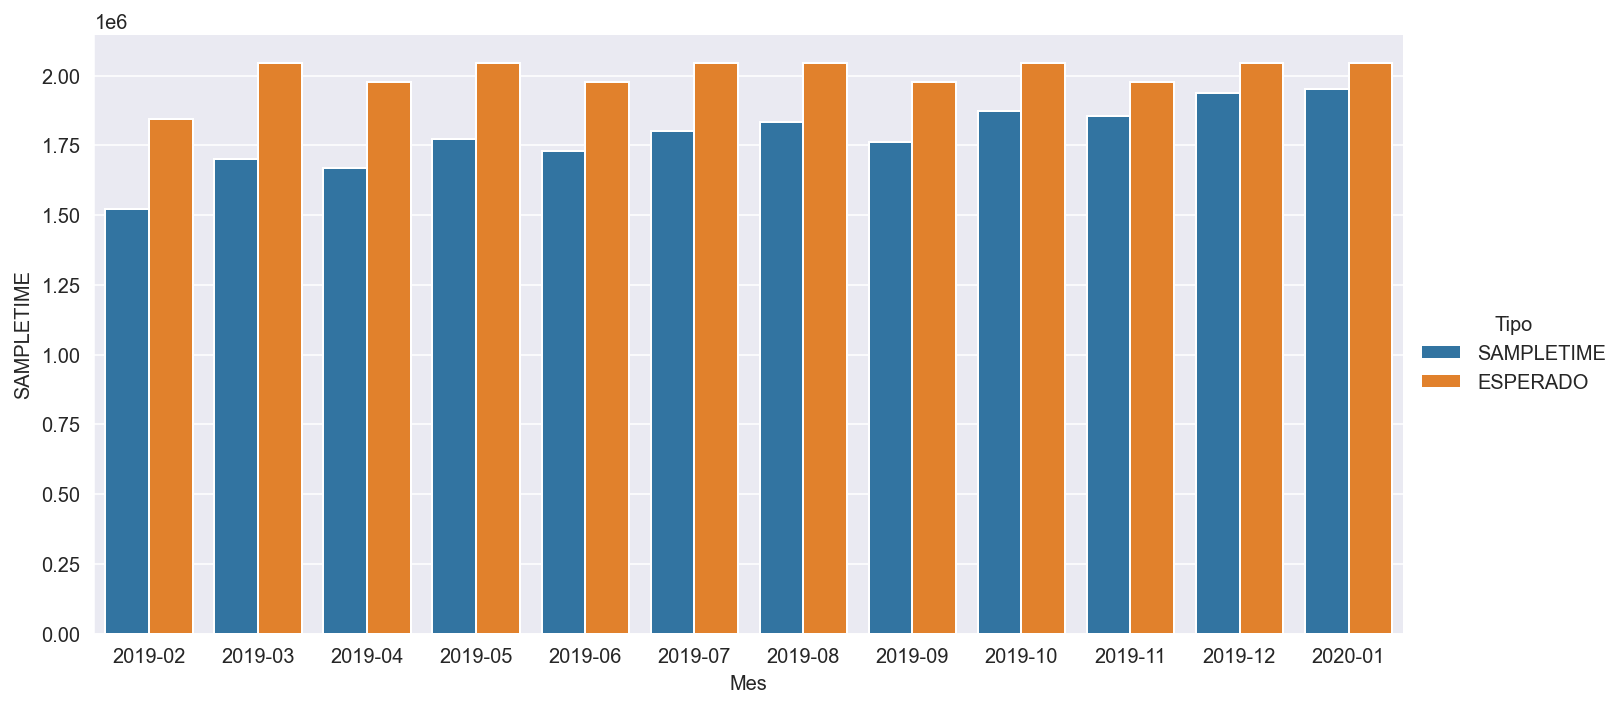

In [61]:
sns.catplot(data=df2, x='Mes', y='SAMPLETIME', kind='bar', hue='Tipo', aspect=2)

Vemos como, efectivamente, a medida que avanzan los meses el número de valores se acerca más al esperado

## ¿Si sumamos los deltas enteros y decimales conseguimos la resta entre el máx y el min de READINGINTEGER?

Lo ideal sería que si sumamos los valores de DELTAINTEGER y DELTATHOUSANDTH, obtengamos la resta entre el valor máximo y el mínimo de READINGINTEGER. Esto se empieza a complicar cuando comprobamos que en algunos casos el máx READINGTHOUSANDTH es +- 10 y en otros 100. Por ejemplo en ID 0 el máximo valor en READINGTHOUSANDTH es 8, y dividiendo entre 10 obtenemos el valor exacto:

In [62]:
df_prueba = df.loc[0].sort_values('SAMPLETIME')
df_prueba.describe()

,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,8759.000000,8759.000000,8759.000000,8759.000000
mean,383306.944857,0.029684,11.784564,0.039959
std,29487.925728,0.421001,20.465775,0.506412
min,331710.000000,0.000000,0.000000,0.000000
25%,357061.500000,0.000000,0.000000,0.000000
50%,384652.000000,0.000000,3.000000,0.000000
75%,408658.500000,0.000000,15.000000,0.000000
max,434966.000000,8.000000,264.000000,8.000000


In [63]:
print(df_prueba["READINGINTEGER"].max() - df_prueba["READINGINTEGER"].min())

print(df_prueba["DELTAINTEGER"].sum())

print((df_prueba["DELTATHOUSANDTH"]/10).sum())

103256
103221
35.0


Pero por ejemplo, en ID 1 el máximo es 98, por lo que deberíamos dividir entre 100 pero no da exacto (porque para algunas horas sí habría que hacerlo entre 10):

In [65]:
df_prueba = df.loc[1].sort_values('SAMPLETIME')
df_prueba.describe()

,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,8759.000000,8759.000000,8759.000000,8759.000000
mean,8182.789930,4.137459,0.433497,3.580317
std,1204.641522,15.364374,3.008305,12.710341
min,5825.000000,0.000000,0.000000,0.000000
25%,7069.000000,0.000000,0.000000,0.000000
50%,8202.000000,0.000000,0.000000,0.000000
75%,9183.000000,0.000000,0.000000,0.000000
max,10092.000000,98.000000,108.000000,89.000000


In [66]:
print(df_prueba["READINGINTEGER"].max() - df_prueba["READINGINTEGER"].min())

print(df_prueba["DELTAINTEGER"].sum())

print((df_prueba["DELTATHOUSANDTH"]/100).sum())

4267
3797
313.59999999999997


Por tanto, como no podremos tratar de una forma adecuada los valores decimales, creemos que lo mejor será directamente descartar esas columnas, ya que no deberían afectar apenas a la solución final

## Números negativos

Existen varios contadores para los cuales todos sus valores son negativos, lo cual tendremos que arreglar en el script de predicción:

In [68]:
df.loc[2711].sort_values('SAMPLETIME').head(10)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
2711,2019-10-08 14:25:03,-8345,0.0,0,0.0
2711,2019-10-08 15:25:03,-8498,0.0,-153,0.0
2711,2019-10-08 16:25:03,-8592,0.0,-94,0.0
2711,2019-10-08 17:25:03,-8756,0.0,-164,0.0
2711,2019-10-08 18:25:02,-8856,0.0,-100,0.0
2711,2019-10-08 19:25:02,-8878,0.0,-22,0.0
2711,2019-10-08 20:25:02,-8879,0.0,-1,0.0
2711,2019-10-08 21:25:02,-8880,0.0,-1,0.0
2711,2019-10-08 22:25:03,-8880,0.0,0,0.0


## Problemas con el `DELTAINTEGER`

Cuando hay "valores perdidos" (horas para las que no existe una fila en un ID), la información del consumo que se ha realizado en ese intervalo de tiempo la podemos obtener calculando las diferencias en el `READINGINTEGER`, no sirviéndonos de mucho `DELTAINTEGER`:

In [70]:
df.loc[2746].sort_values('SAMPLETIME').head(10)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
2746,2019-08-14 02:26:34,523869,0.0,0,0.0
2746,2019-08-14 03:26:34,523869,0.0,0,0.0
2746,2019-08-14 04:26:34,523869,0.0,0,0.0
2746,2019-08-14 05:26:34,523869,0.0,0,0.0
2746,2019-08-28 22:25:51,532612,0.0,0,0.0
2746,2019-08-28 23:25:51,532613,0.0,1,0.0
2746,2019-08-29 00:25:51,532613,0.0,0,0.0
2746,2019-08-29 01:25:51,532613,0.0,0,0.0


## Cada contador tiene horas distintas

Una cosa que podemos ver fácilmente si nos fijamos en los valores de SAMPLETIME es que los minutos y segundos parece que se han establecido aleatoriamente, por lo que lo más logico es pensar que no influyen

### Visualización

In [72]:
df.groupby(['SAMPLETIME']).size().count()

13516088

Hay 13516088 valores distintos de fecha/hora. Los tenemos que dejar en 8759

### Convertir tiempos a horas enteras (16:04:57 a 16:00:00)

Podemos probar estableciendo directamente los minutos y segundos a 0. Así, podemos ver como arreglamos la mayoría de casos, quedándonos en la mayoría de los casos 1 hora por ID, que es lo que queremos. Sin embargo, tendremos que corregir las horas que aparecen 3, 4 y 5 veces, combinando sus valores en una única entrada:

In [73]:
df['SAMPLETIME'] = df['SAMPLETIME'].apply(lambda x:x.replace(minute=0,second=0))

Podemos ver cómo aunque casi todas están bien, tenemos 2 ocurrencias de 3 horas repetidas, 104 de 5 y 34882 de 4 (cosa que ya sabíamos porque vimos que en algunos casos el contador contaba cada cuarto de hora)

In [74]:
df_temp = df.groupby(['ID','SAMPLETIME']).size().sort_values()
unique2, counts2 = np.unique(df_temp, return_counts=True)
dict(zip(unique2, counts2))

{1: 21264774, 3: 2, 4: 34882, 5: 104}

### Resultado:

Si cargamos el fichero `Modelar_Procesado.csv` que hemos creado en el script de predicción:

In [75]:
df = pd.read_csv('data/Modelar_Procesado.csv', index_col='ID', parse_dates=True)
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)
df = df.sort_values(["ID", 'SAMPLETIME'])
df.head()

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
0,2019-02-01 00:00:00,331710,0.0,0,0.0
0,2019-02-01 01:00:00,331710,0.0,0,0.0
0,2019-02-01 02:00:00,331710,0.0,0,0.0
0,2019-02-01 03:00:00,331710,0.0,0,0.0
0,2019-02-01 04:00:00,331710,0.0,0,0.0


Podemos ver como el número de registros por horas va aumentado conforme avanza el tiempo. Esto es malo porque tenemos menos datos de los primeros días de febrero, pero la parte buena es que hay bastantes de las horas anteriores a las que tenemos que predecir

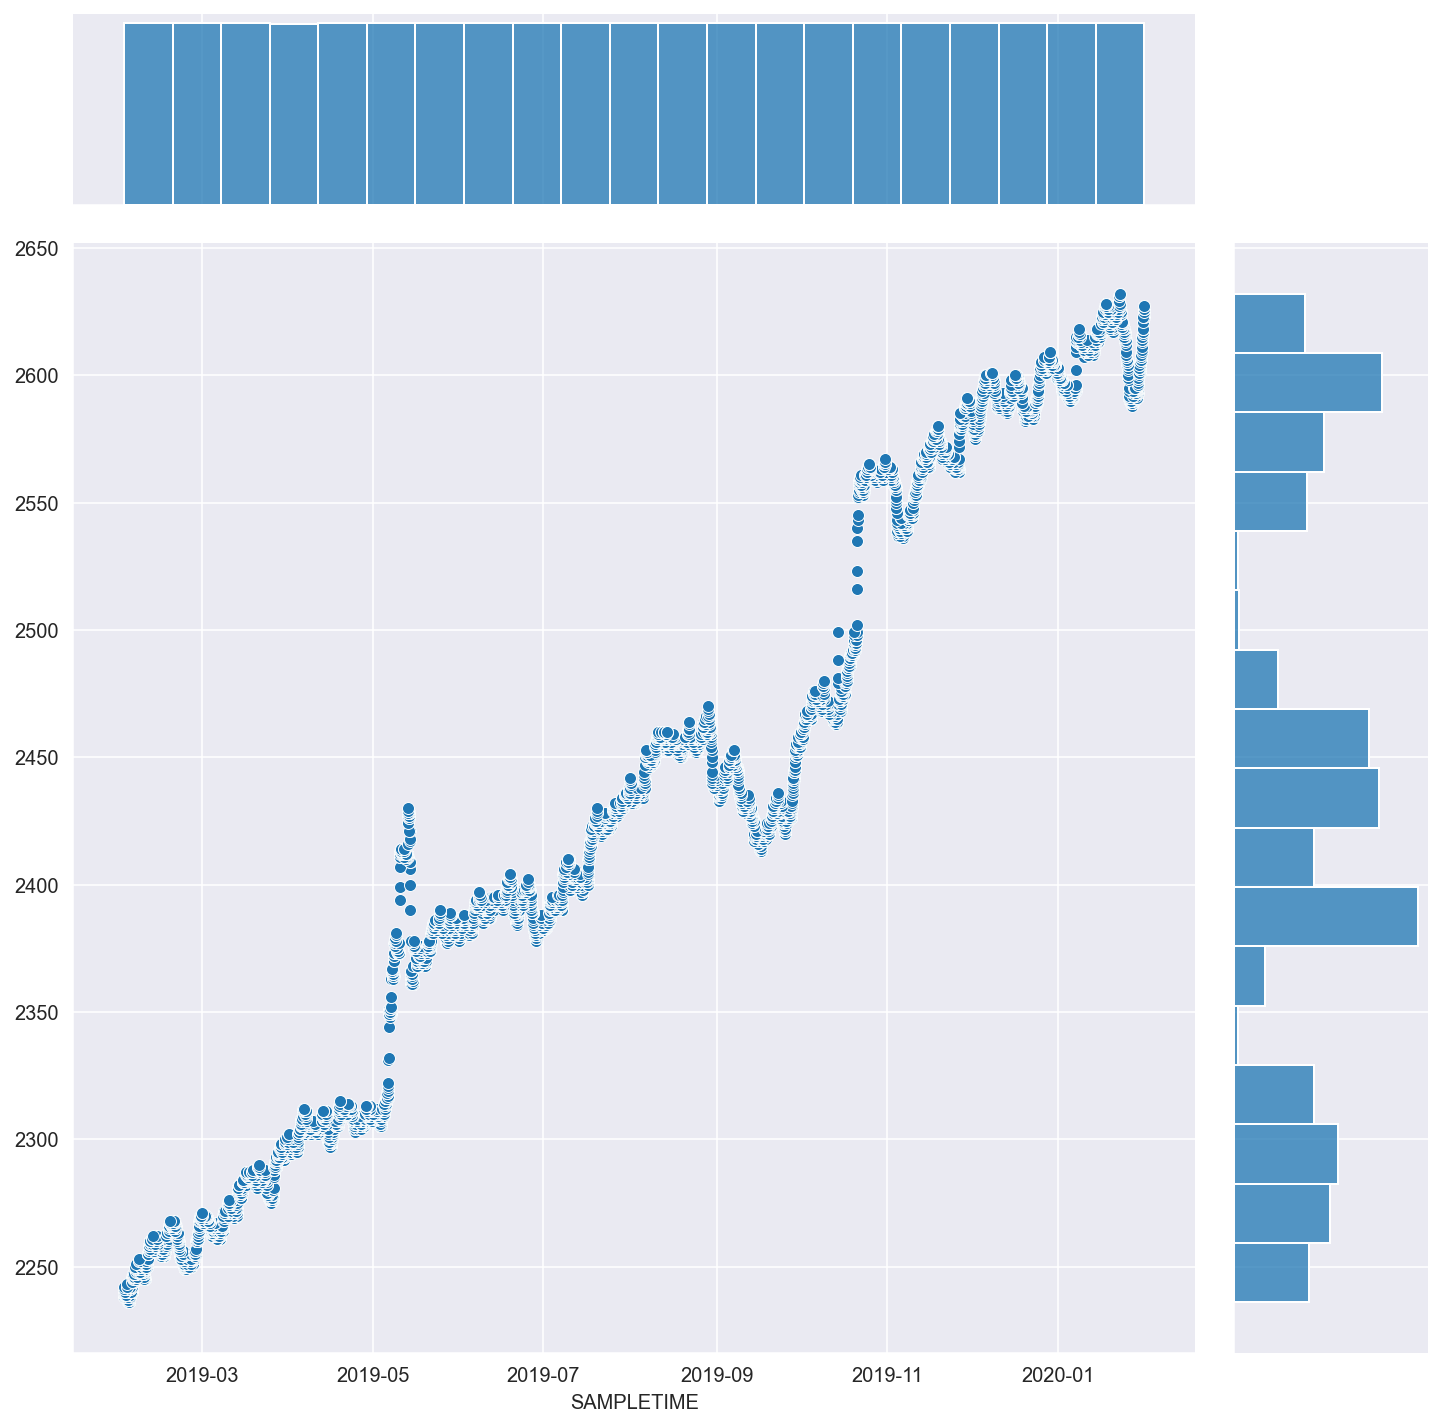

In [76]:
sns.jointplot(data=df.groupby(['SAMPLETIME']).size().sort_values(), kind='scatter', height=10)

## Contadores decrecientes

Hemos visto como los deltas no estaban calculados correctamente en algunos casos. Tampoco nos podemos fiar del `READINGINTEGER`, ya que en bastantes casos no es correcto, con valores decrecientes en lugar de crecientes y cambios muy drásticos.

Dejamos aquí algunos ejemplos muy variopintos, que nos complican crear un método general que arregle todos ellos:

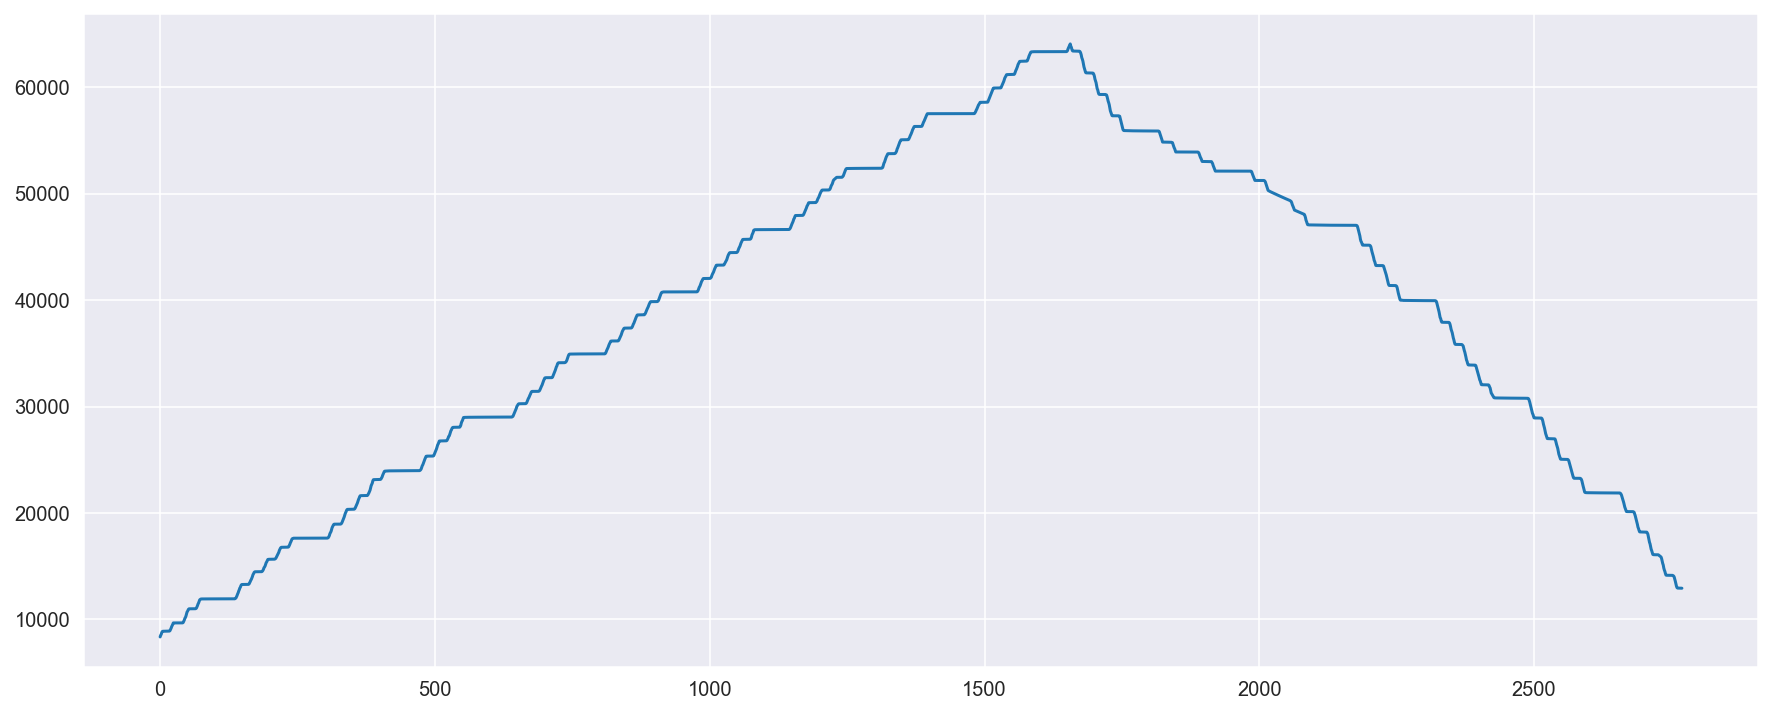

In [80]:
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values)

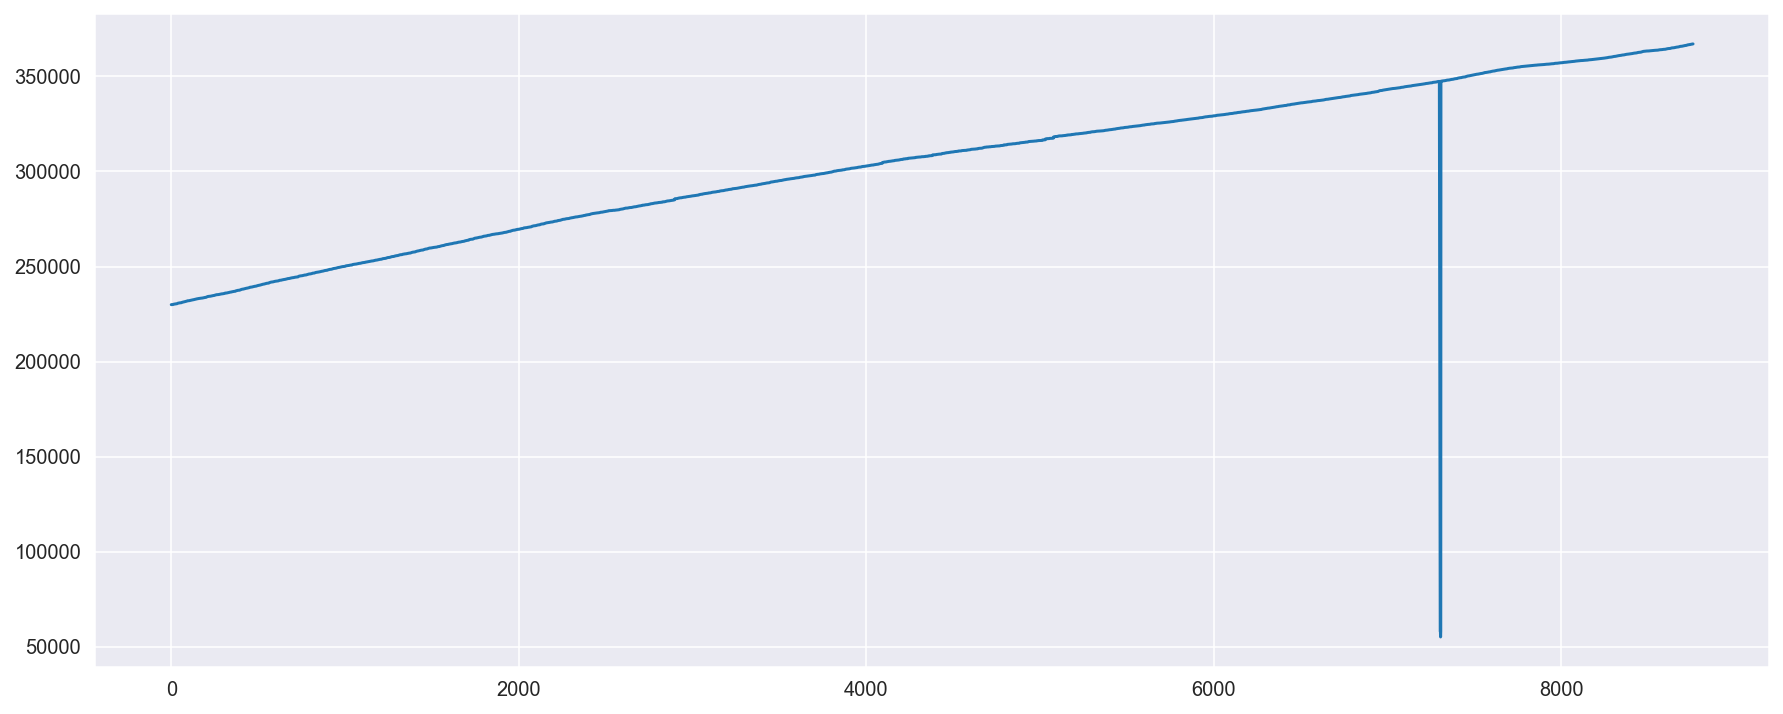

In [79]:
plt.plot(df.loc[57].sort_values('SAMPLETIME')["READINGINTEGER"].values)

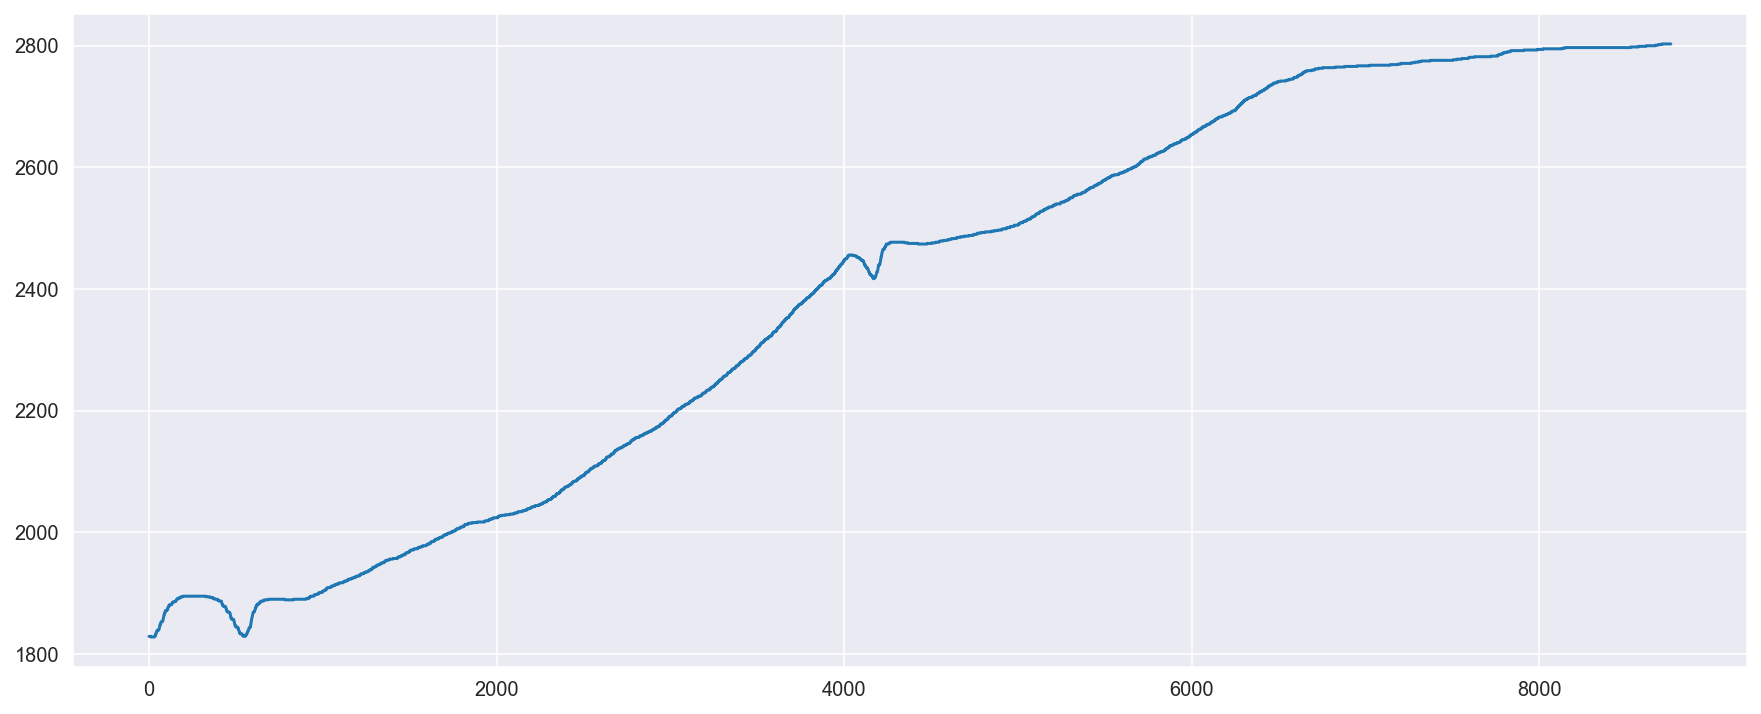

In [81]:
plt.plot(df.loc[896].sort_values('SAMPLETIME')["READINGINTEGER"][:].values)

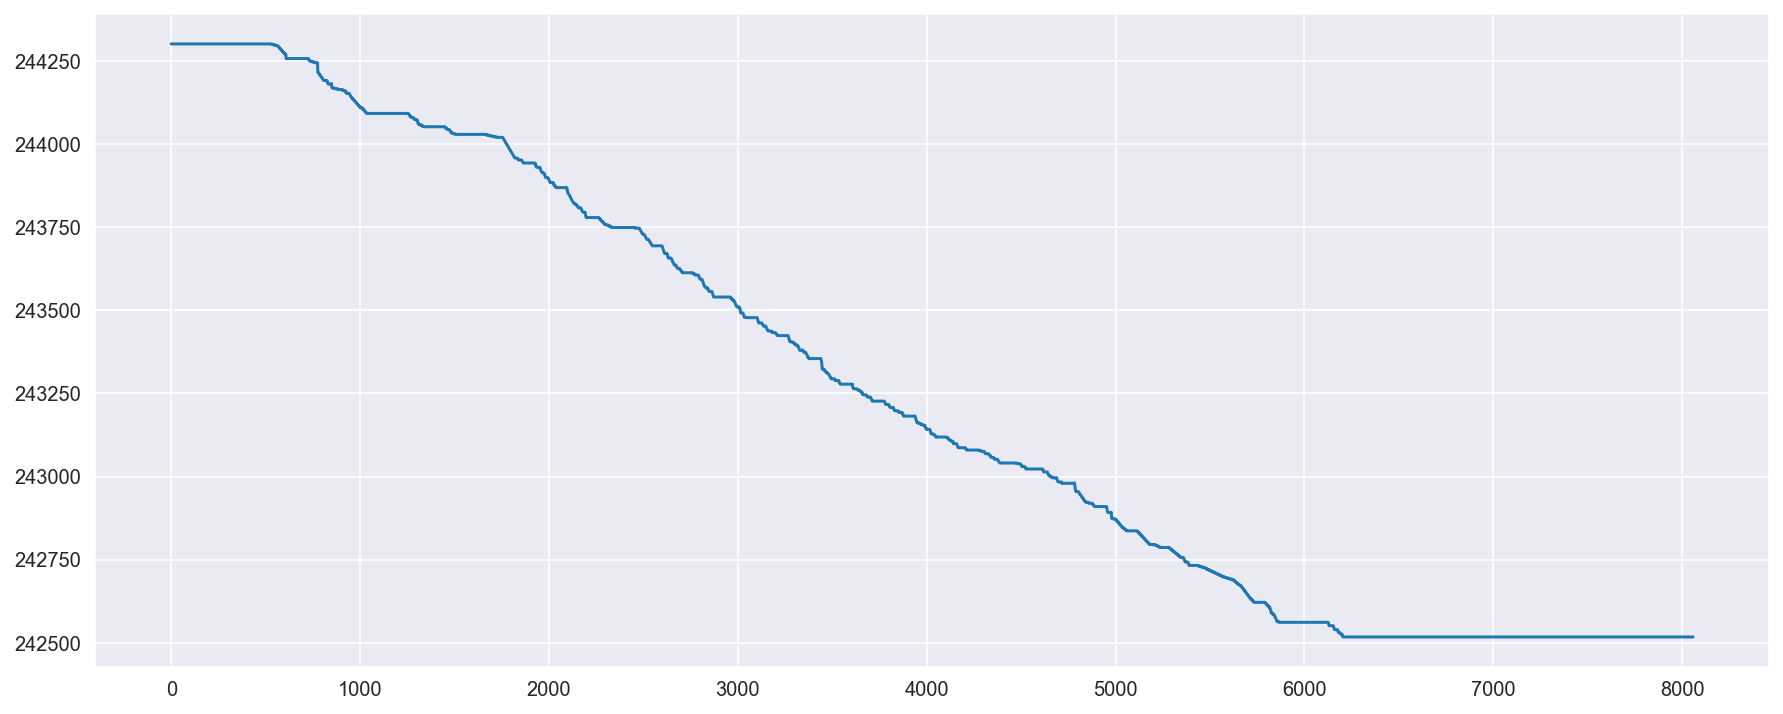

In [82]:
plt.plot(df.loc[138].sort_values('SAMPLETIME')["READINGINTEGER"][:].values)

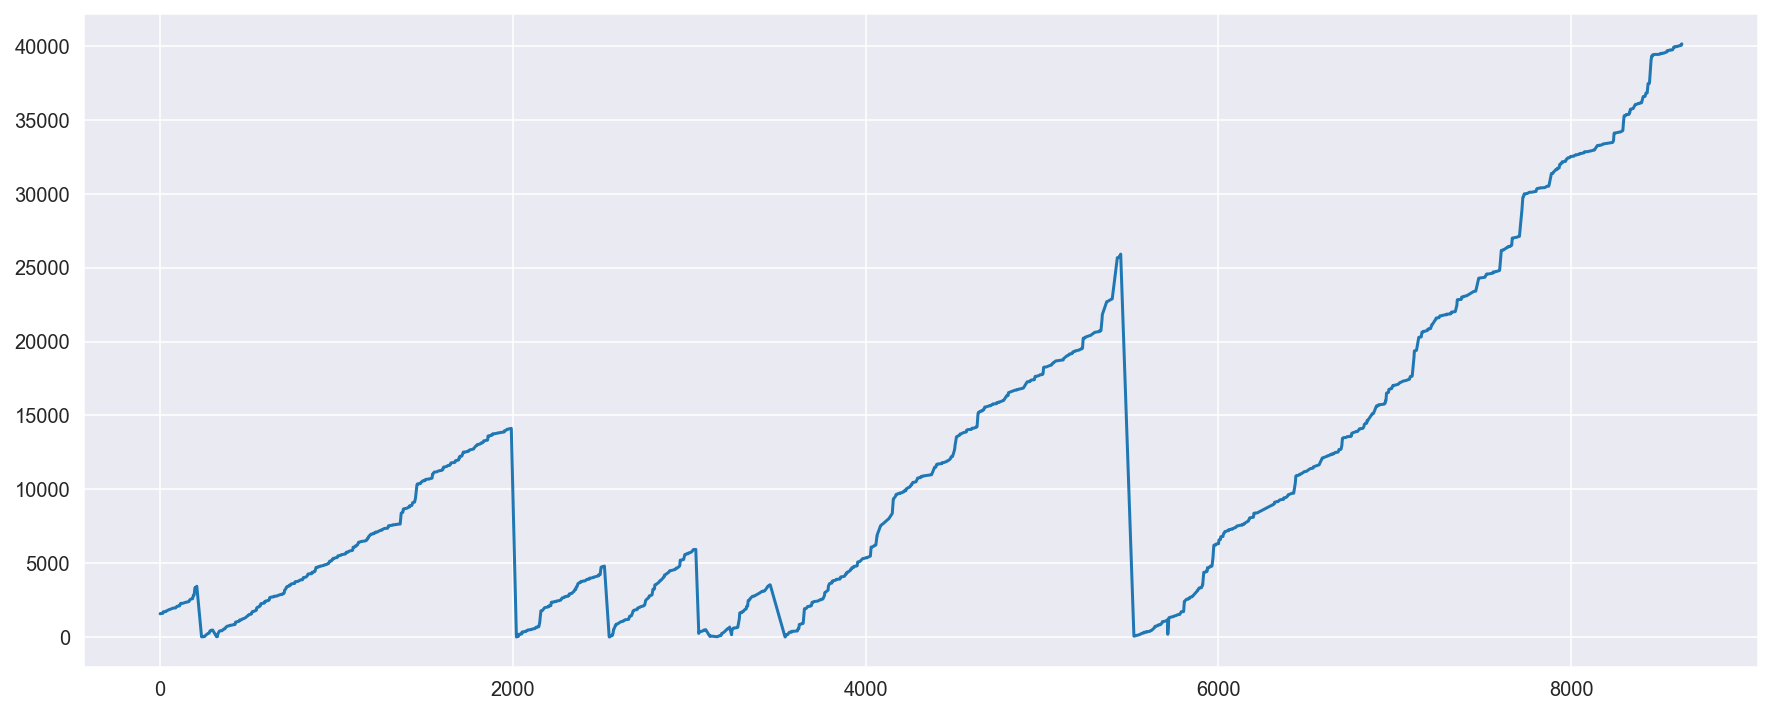

In [83]:
plt.plot(df.loc[1506].sort_values('SAMPLETIME')["READINGINTEGER"][:].values)

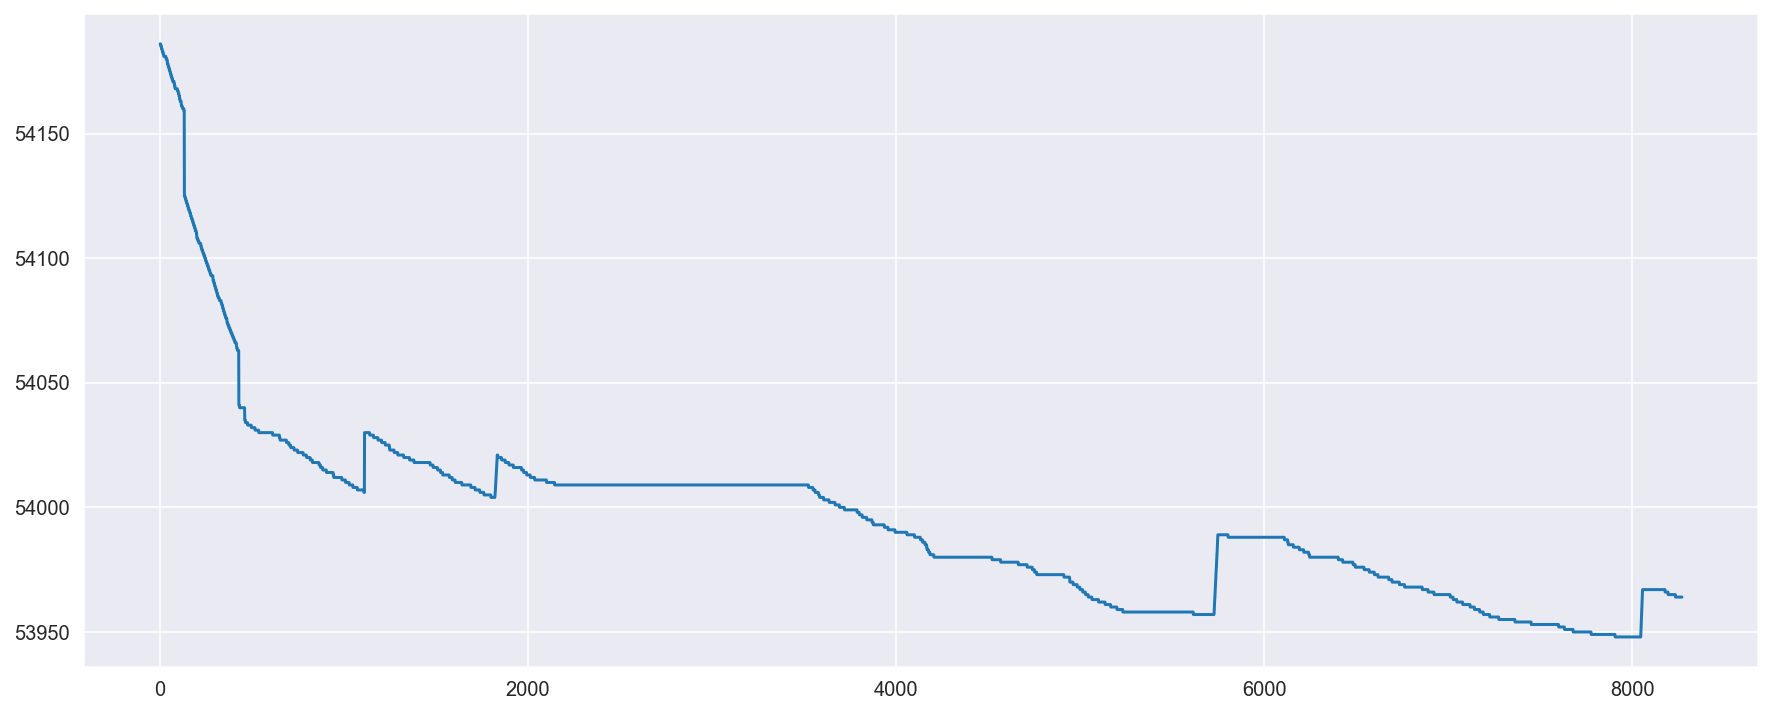

In [84]:
plt.plot(df.loc[2140].sort_values('SAMPLETIME')["READINGINTEGER"][:].values)

### Resultado

Una vez que hemos realizado nuestro procesado en el script de predicción (resultando en el fichero `Modelar_Procesado_2.csv`), obtenemos resultados como los siguientes:

In [7]:
df = pd.read_csv('data/Modelar_Procesado_2.csv', index_col='ID', parse_dates=True)
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)
df = df.sort_values(["ID", 'SAMPLETIME'])
df.head()

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
0,2019-02-01 00:00:00,331710,0.0,0,0.0
0,2019-02-01 01:00:00,331710,0.0,0,0.0
0,2019-02-01 02:00:00,331710,0.0,0,0.0
0,2019-02-01 03:00:00,331710,0.0,0,0.0
0,2019-02-01 04:00:00,331710,0.0,0,0.0


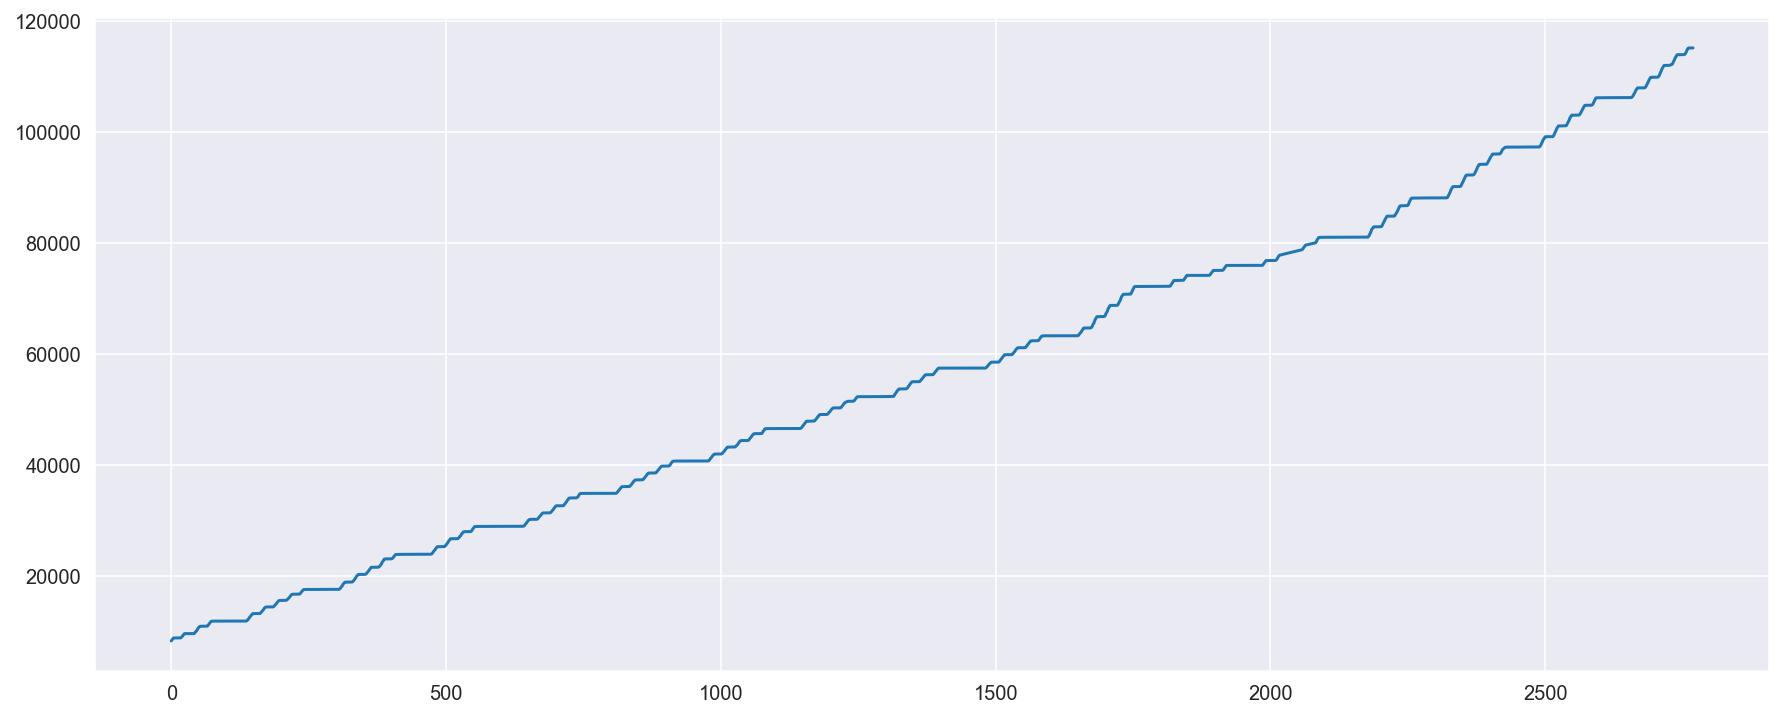

In [119]:
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values)

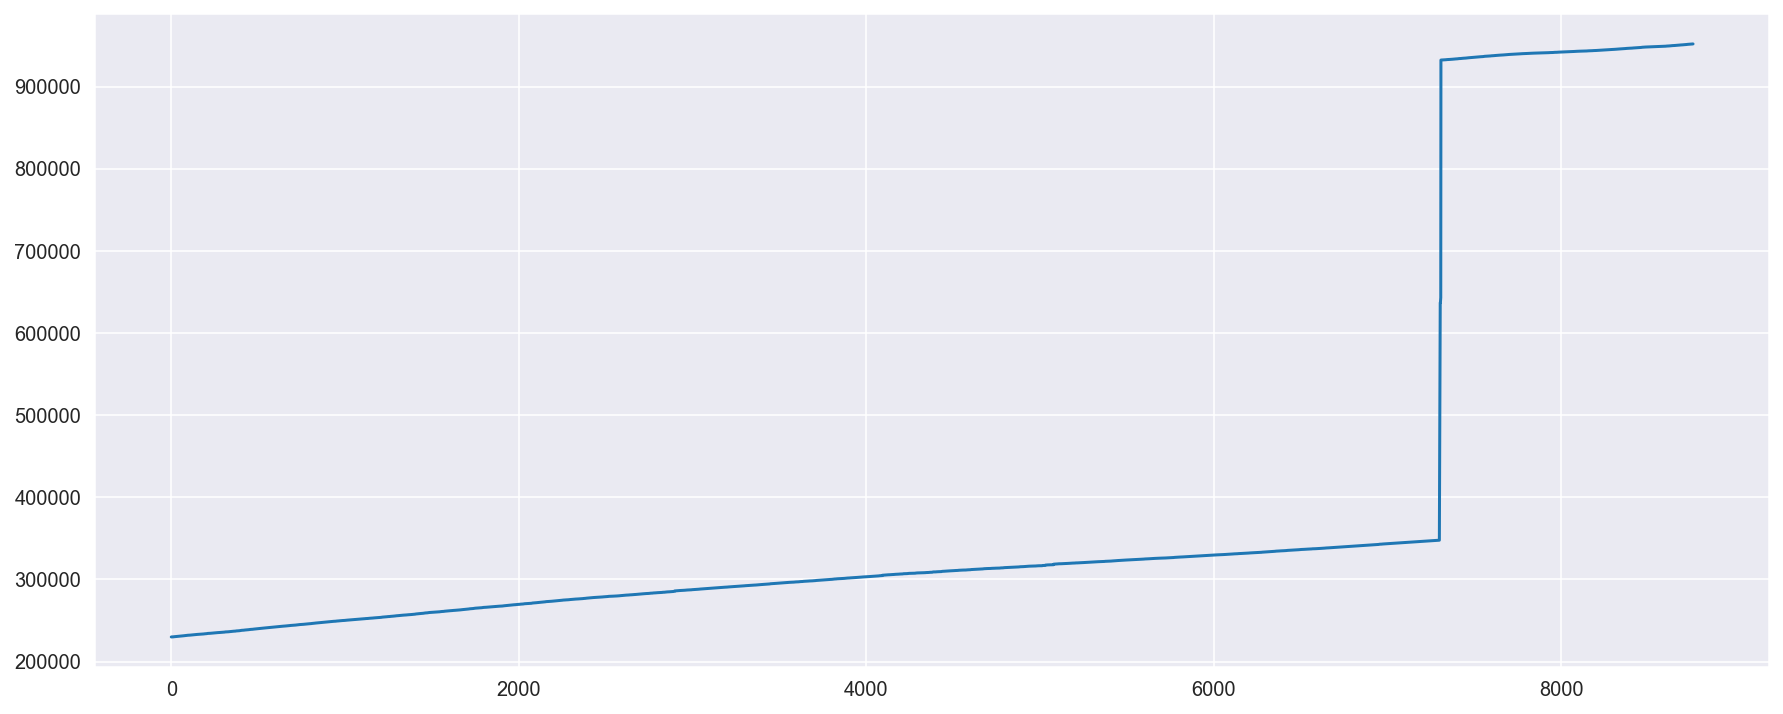

In [120]:
plt.plot(df.loc[57].sort_values('SAMPLETIME')["READINGINTEGER"].values)

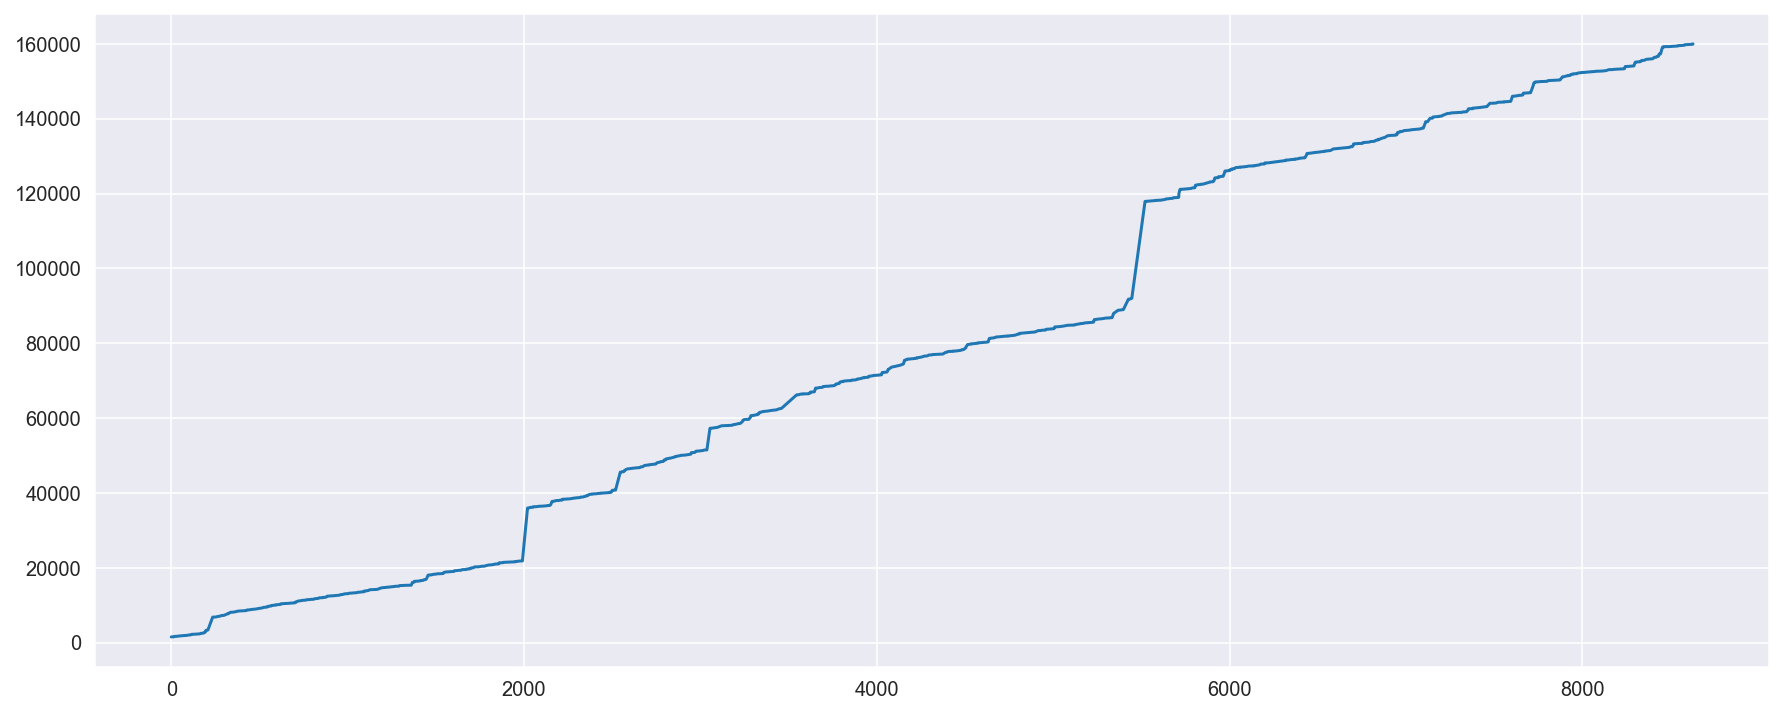

In [8]:
plt.plot(df.loc[1506].sort_values('SAMPLETIME')["READINGINTEGER"][:].values)

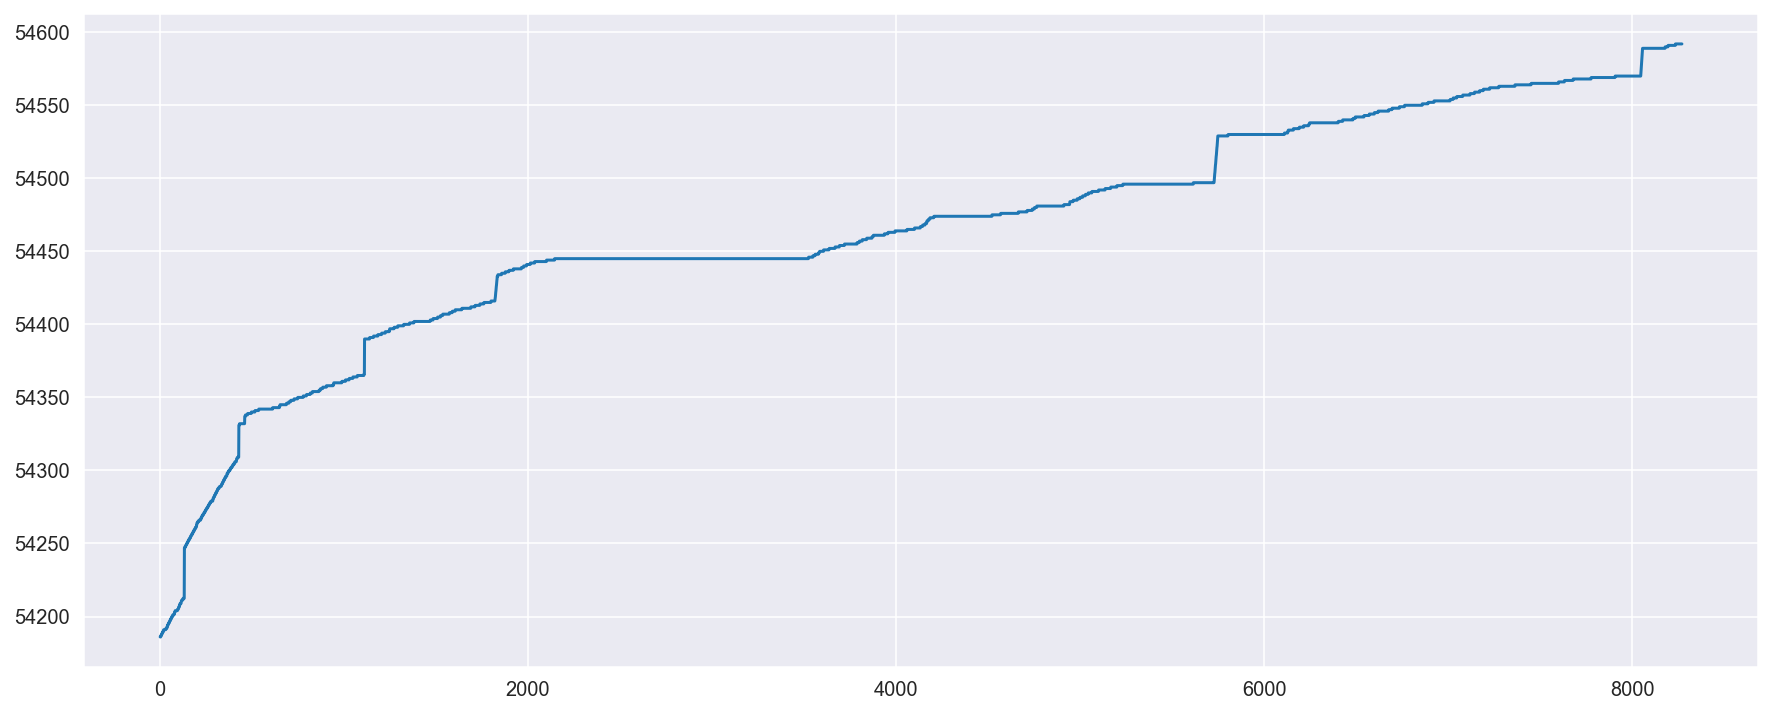

In [121]:
plt.plot(df.loc[2140].sort_values('SAMPLETIME')["READINGINTEGER"][:].values)

Podemos ver cómo en algunos casos lo hemos arreglado bien porque la diferencia entre los valores de cada hora era constante, aunque a veces fueran crecientes y otras decrecientes; pero sin embargo cuando había un salto negativo muy drástico en el valor de `READINTEGER` estamos creando un cambio muy drástico desde una hora a la siguiente (un "escalón")

## Cambios muy drásticos desde una hora a la siguiente

Podemos asumir que los cambios drásticos entre dos horas son anomalías (algunas está claro porque las hemos añadido en el paso anterior, pero otras podían venir "de serie"), por lo que podemos eliminarlas. Sin embargo, hay que tener cuidado con cuándo las eliminamos y cuándo no, ya que los consumos de agua entre contadores son muy dispares, y mientras que en uno un consumo de 100 puede parecer una anomalía si observamos su gráfica, en otros casos puede ser un valor toralmente normal. 

Este sería el caso, por ejemplo, de los dos siguientes contadores, en los que los cambios que parecen drásticos del primero son en realidad menores que los consumos normales del segundo:

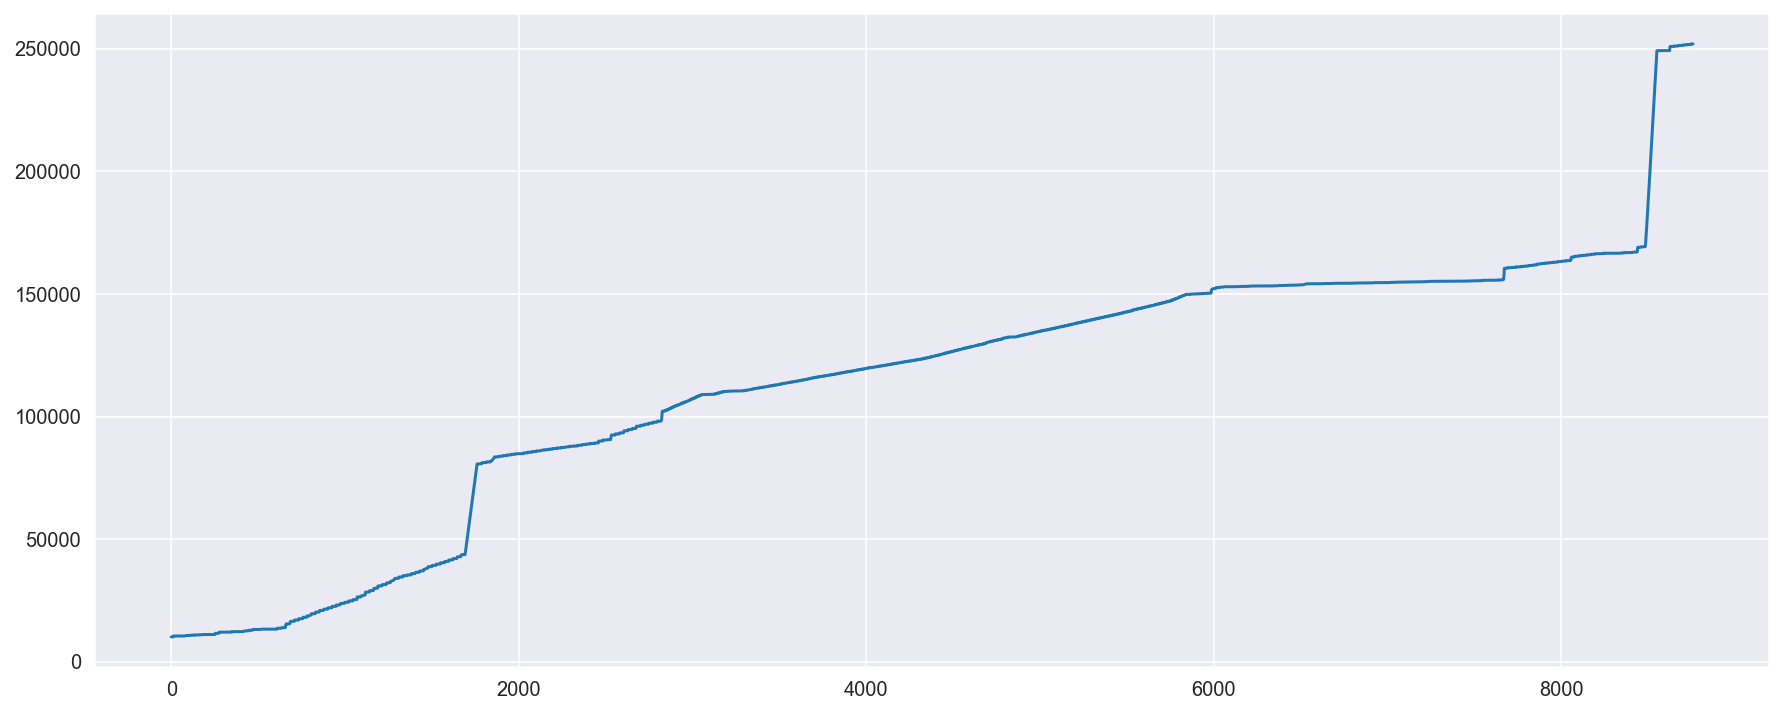

In [88]:
plt.plot(df.loc[51].sort_values('SAMPLETIME')["READINGINTEGER"].values)

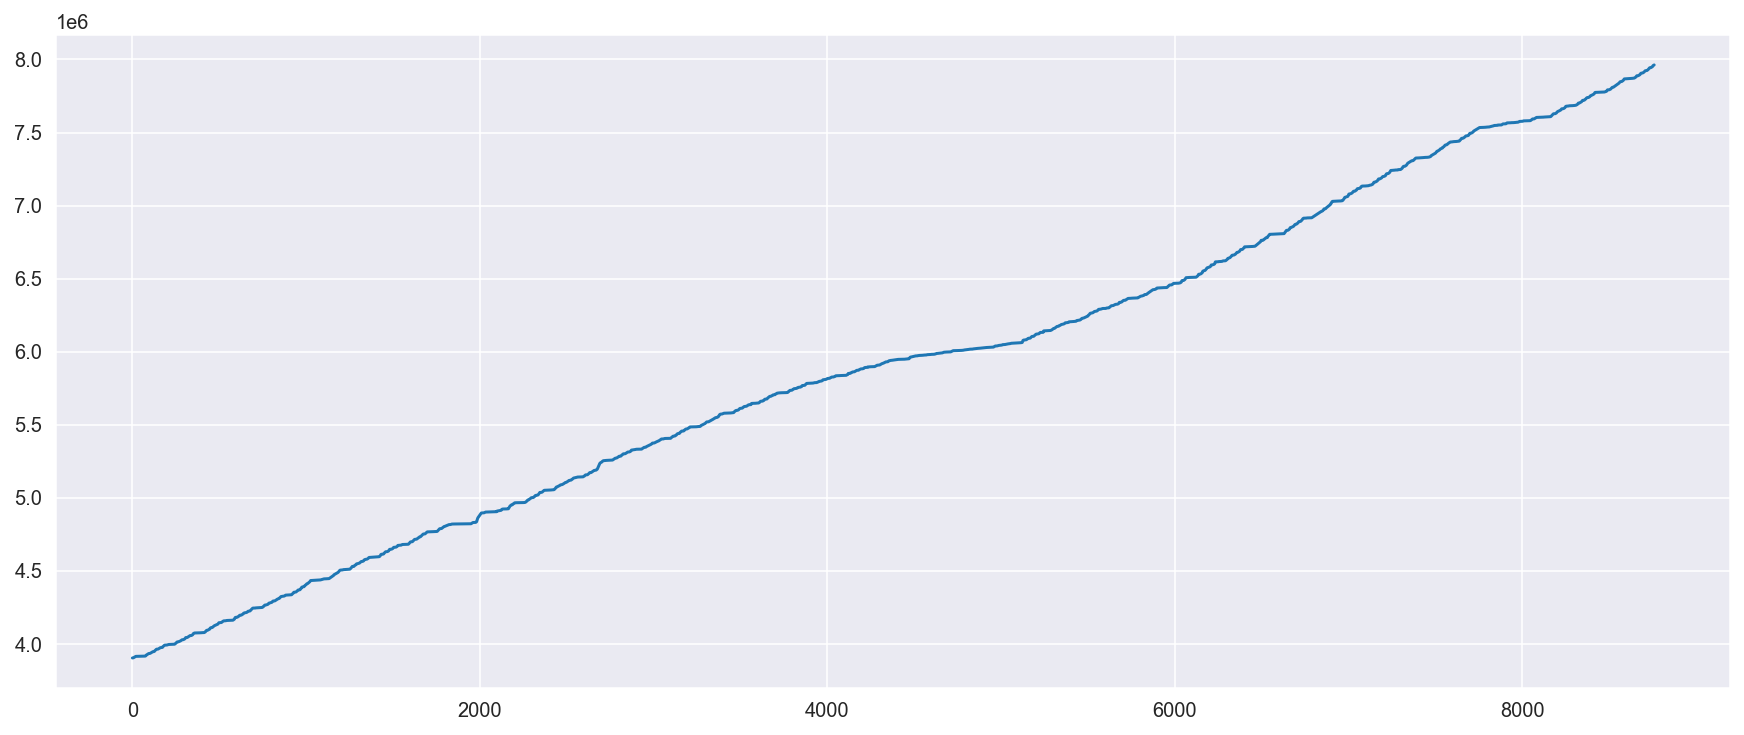

In [89]:
plt.plot(df.loc[42].sort_values('SAMPLETIME')["READINGINTEGER"].values)

## Imputación de valores

Vamos a probar dos imputadores de Scikit para ver cómo se comportan:
- KNNImputer
- IterativeImputer

In [113]:
df = pd.read_csv('data/Modelar_Procesado_conNaN.csv')
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)
df = df.sort_values(["ID", 'SAMPLETIME'])
df = df.set_index('ID')

df = df.drop(['MES','AÑO'], axis=1)
scaler = MinMaxScaler()
df[['Temp', 'H.Rel', 'R.Sol', 'Precip', 'OCUPACIÓN DIARIA COMPLETA', 'PERNOTACIONES TOTAL', 'OCUPACIÓN TOTAL']] = scaler.fit_transform(df[['Temp', 'H.Rel', 'R.Sol', 'Precip', 'OCUPACIÓN DIARIA COMPLETA', 'PERNOTACIONES TOTAL', 'OCUPACIÓN TOTAL']])

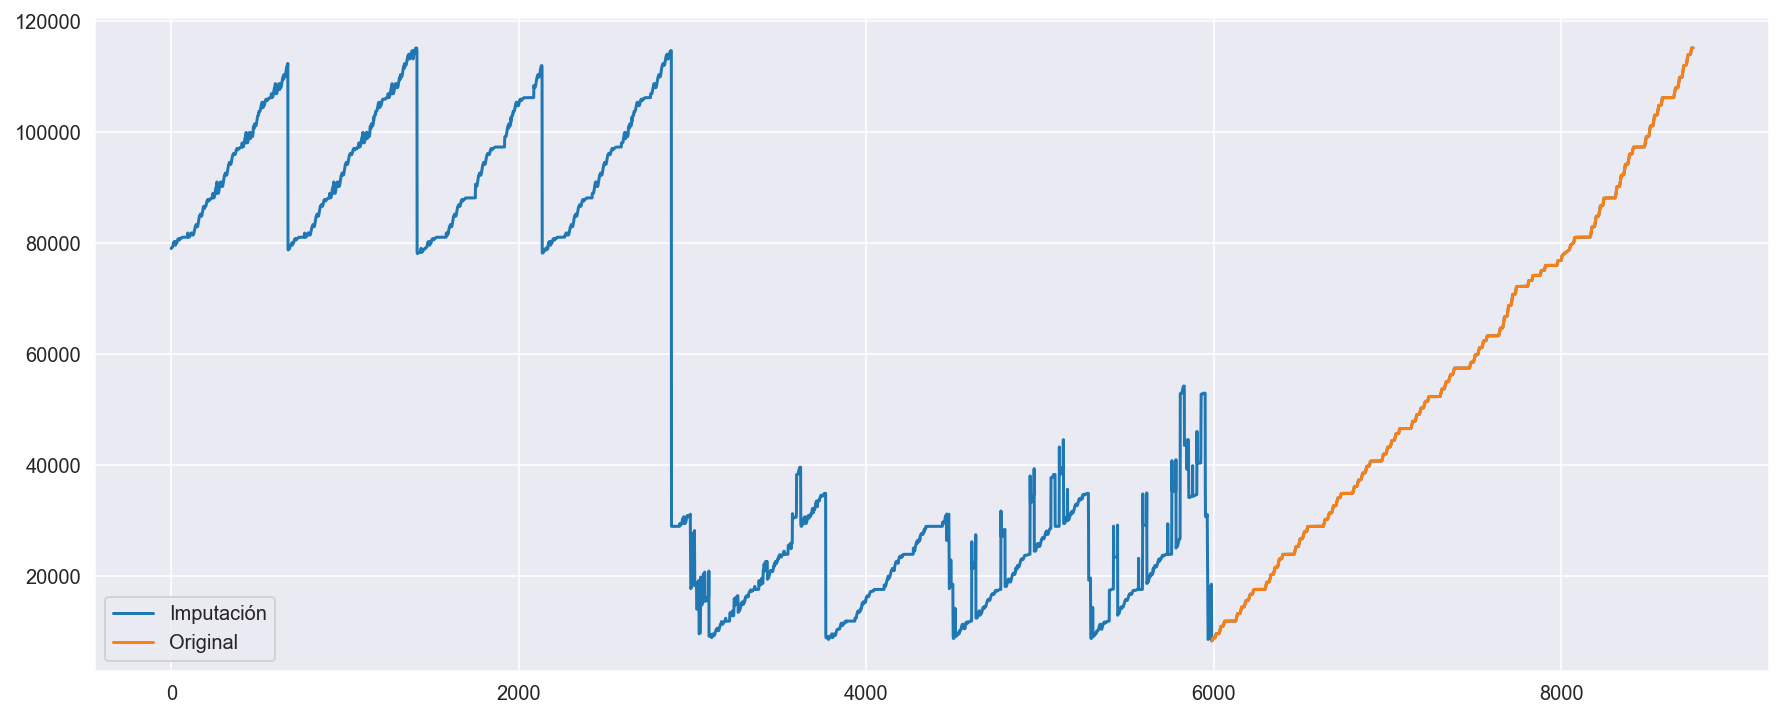

In [114]:
imputer=KNNImputer(n_neighbors=5, weights="uniform")
imputed_dataset = imputer.fit_transform(df.loc[2711].drop('SAMPLETIME',axis=1))

plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
plt.legend()
plt.show()

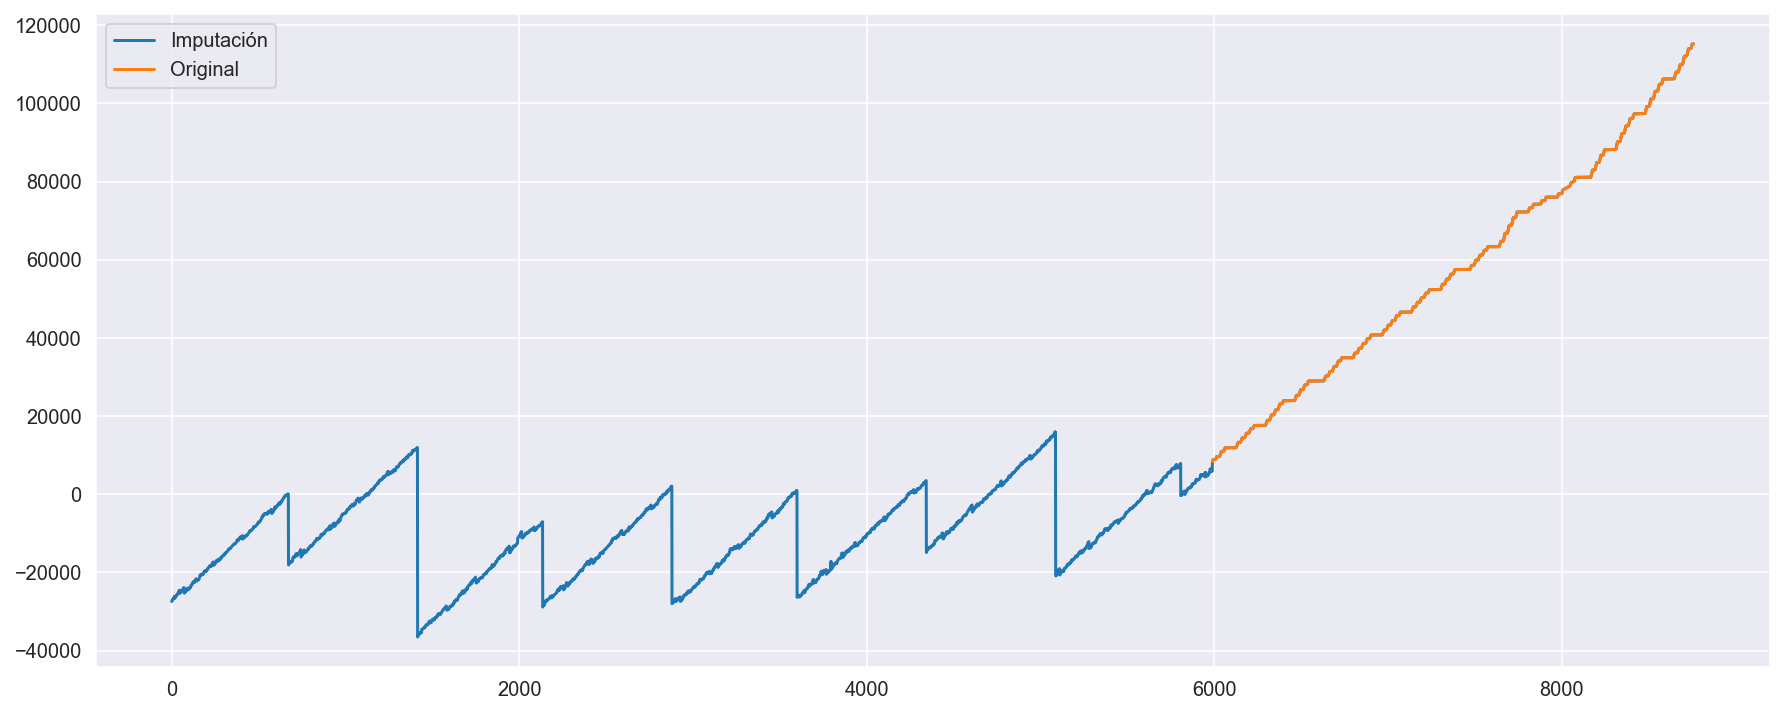

In [115]:
imputer=IterativeImputer(max_iter=10, random_state=42)
imputed_dataset = imputer.fit_transform(df.loc[2711].drop('SAMPLETIME',axis=1))

plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
plt.legend()
plt.show()

Parece que el `IterativeImputer` va mejor (aunque tenemos que arreglar los valores decrecientes)

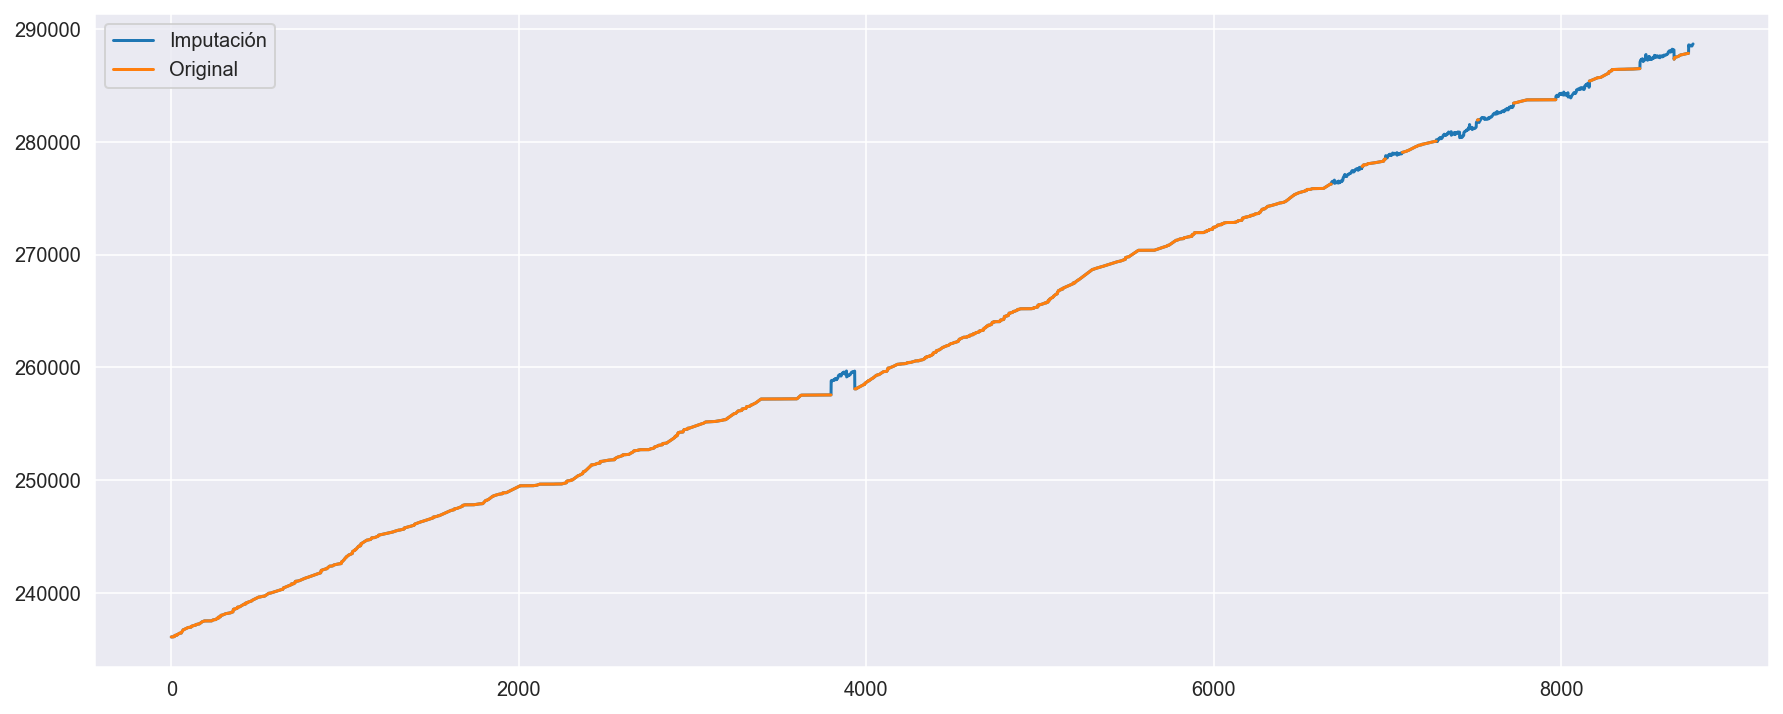

In [116]:
imputer=IterativeImputer(max_iter=10, random_state=42)
imputed_dataset = imputer.fit_transform(df.loc[1663].drop('SAMPLETIME',axis=1))

plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
plt.plot(df.loc[1663].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
plt.legend()
plt.show()

Sin embargo parece que el .interpolate() de Pandas es el que mejor nos viene cuando los valores perdidos están en medio de la serie, y cuando no es así podemos usar el IterativeImputer para extrapolar (arreglando luego el resultado, al igual que hicimos antes, eliminando valores decrecientes y saltos muy grandes).

Aquí podemos ver algunos ejemplos del resultado de combinar ambos métodos antes de arreglar la salida:

11


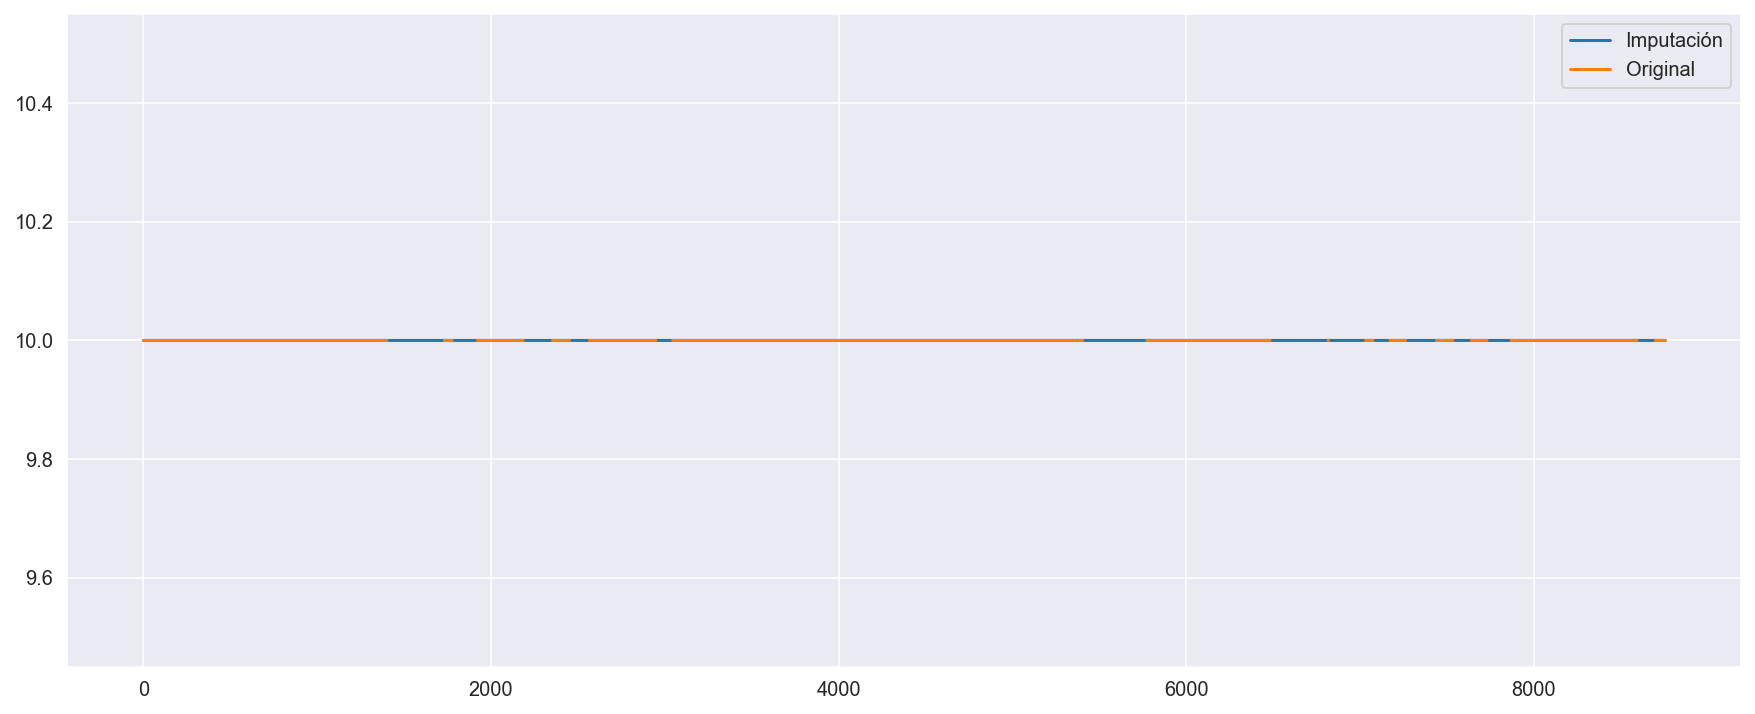

26


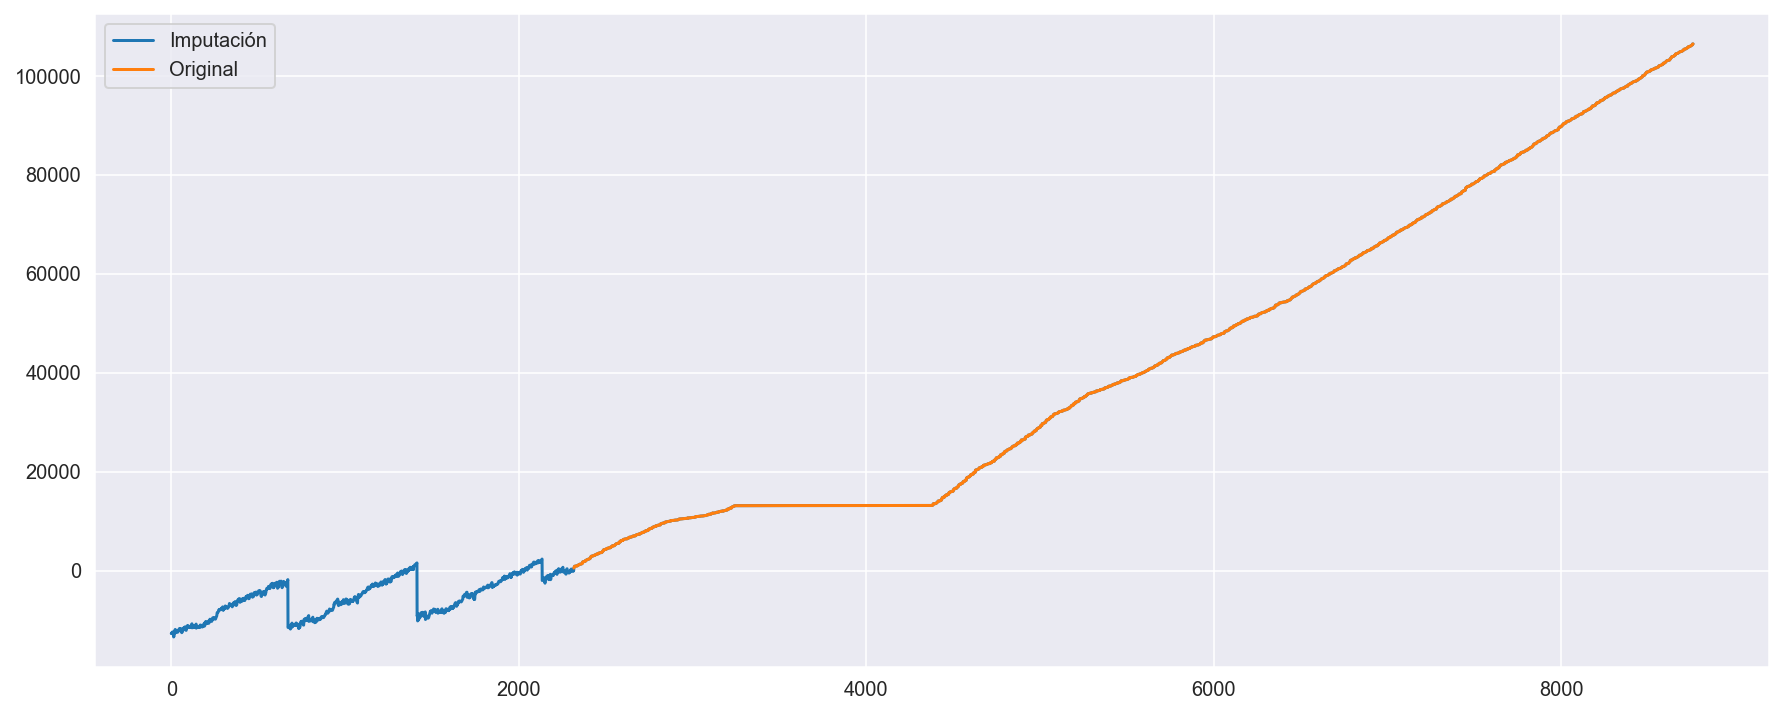

37


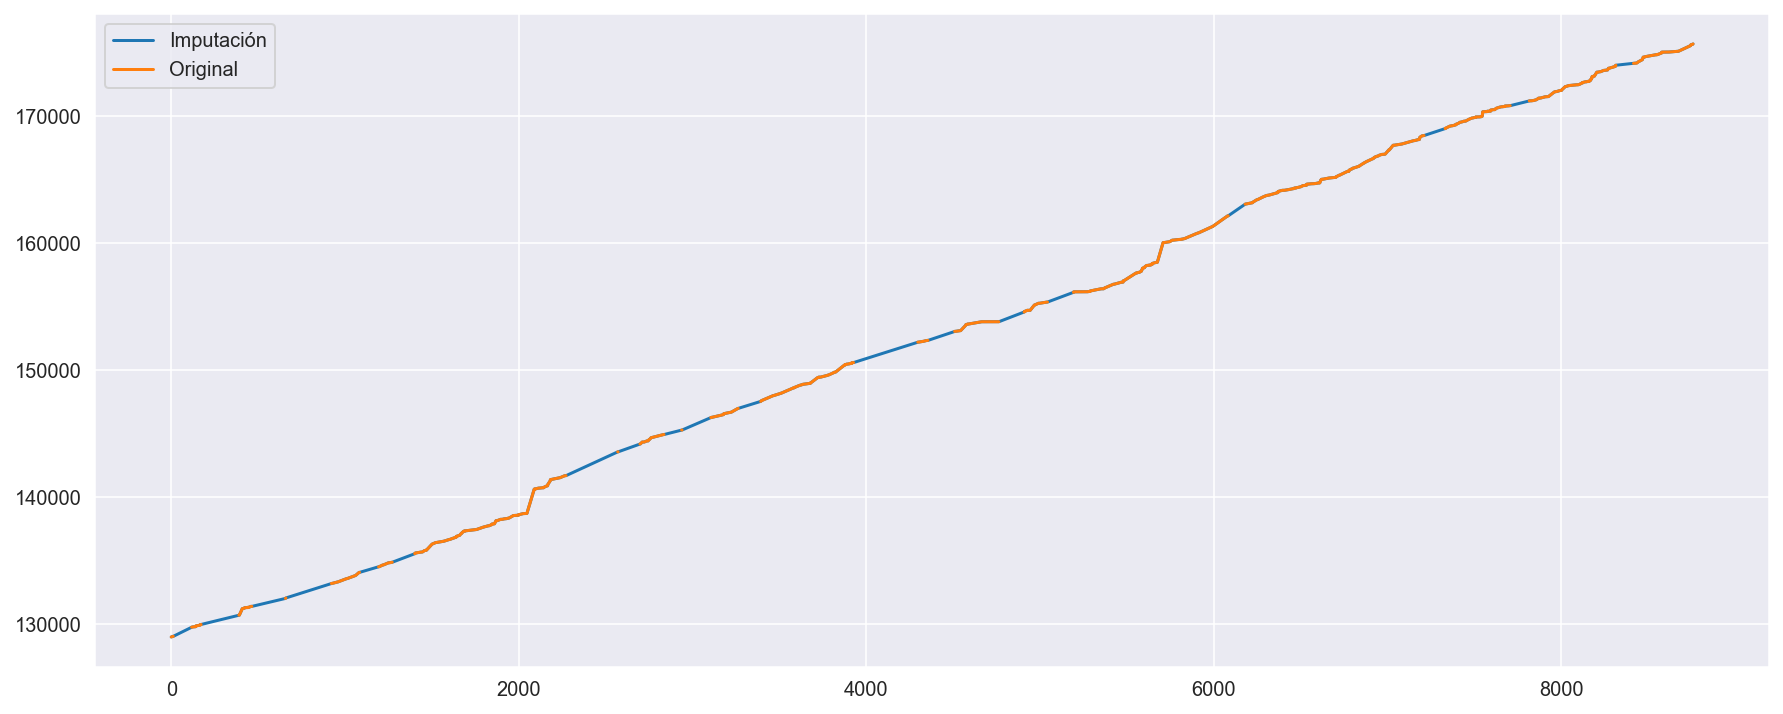

72


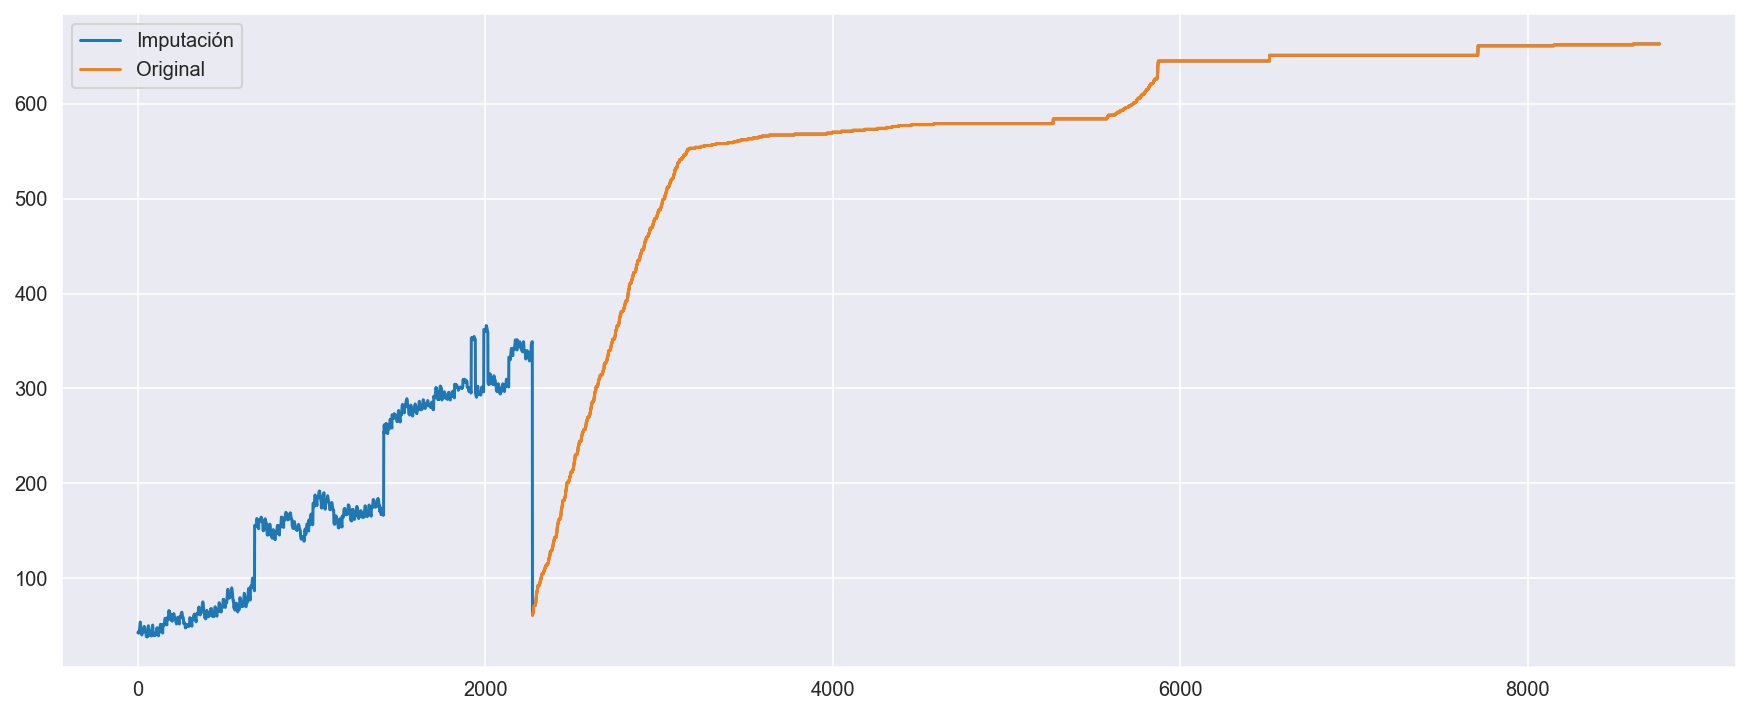

In [117]:
imputer=IterativeImputer(max_iter=10, random_state=42)

# Para cada índice
for i in [11, 26, 37, 72]:
    print(i)
    df_temp = df.loc[i]
    
    imputed_dataset = df.loc[i].drop(['SAMPLETIME'],axis=1).interpolate()
    
    imputed_dataset = imputer.fit_transform(imputed_dataset)

    plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
    plt.plot(df.loc[i].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
    plt.legend()
    plt.show()

### Visualización del arreglo de la salida

Una vez que hemos eliminado los valores descendientes y los saltos, podemos ver cómo el resultado obtenido parece ser bastante bueno:

In [2]:
df = pd.read_csv('data/Modelar_UH2022_DEF.csv', index_col='ID', parse_dates=True)

11


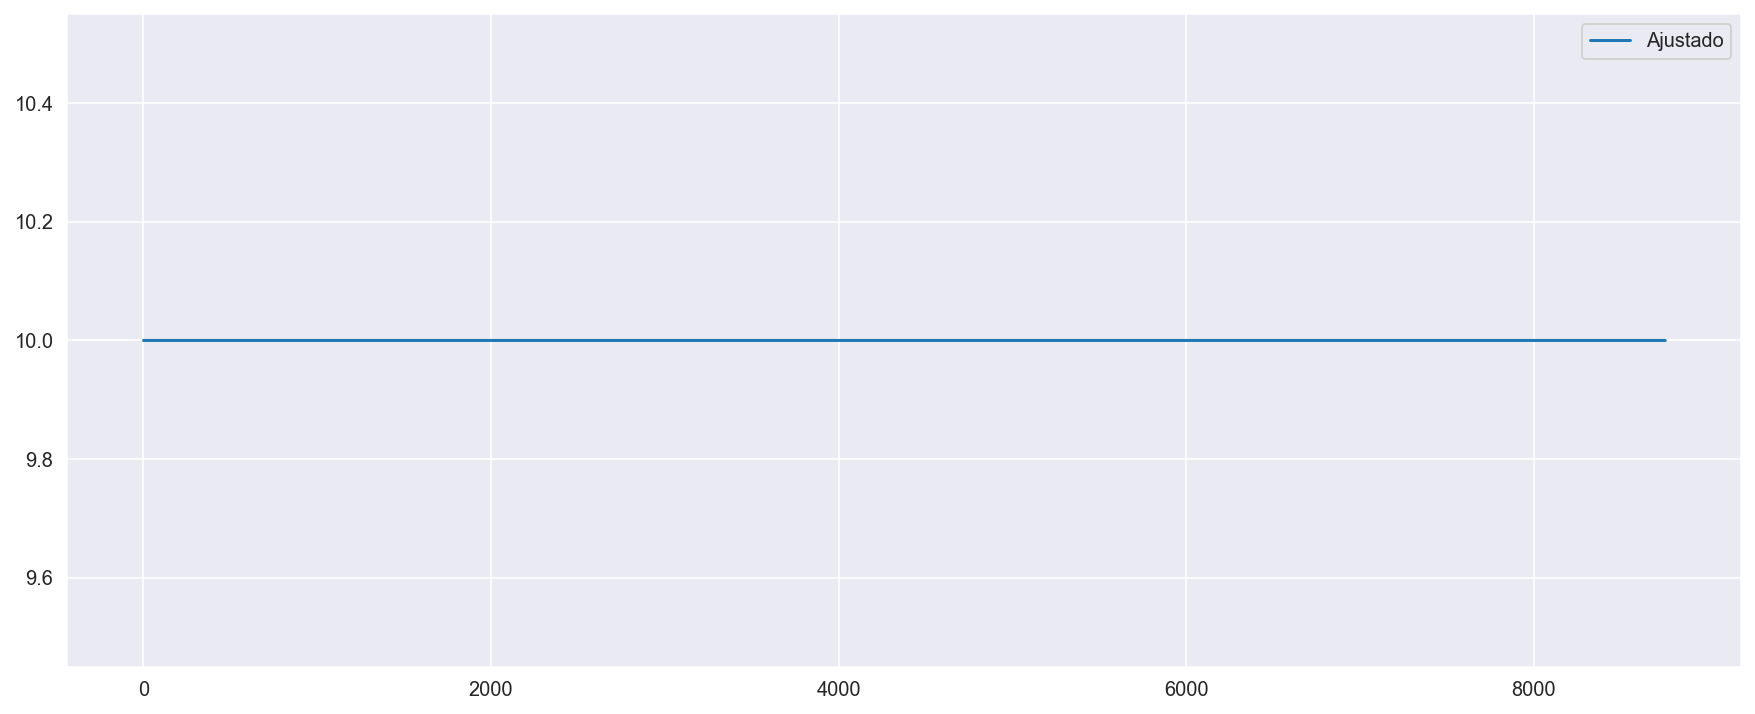

26


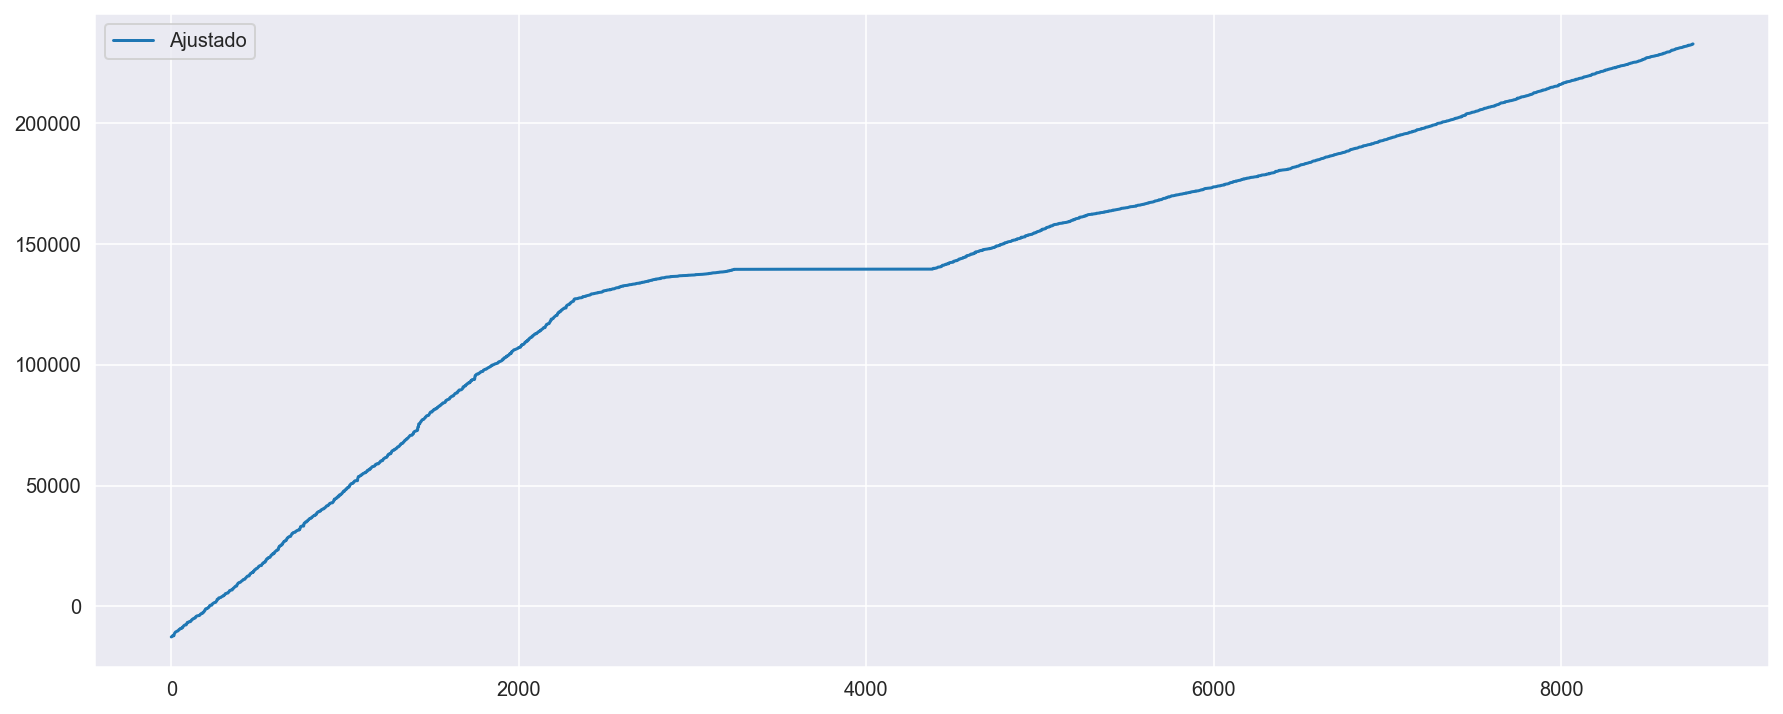

37


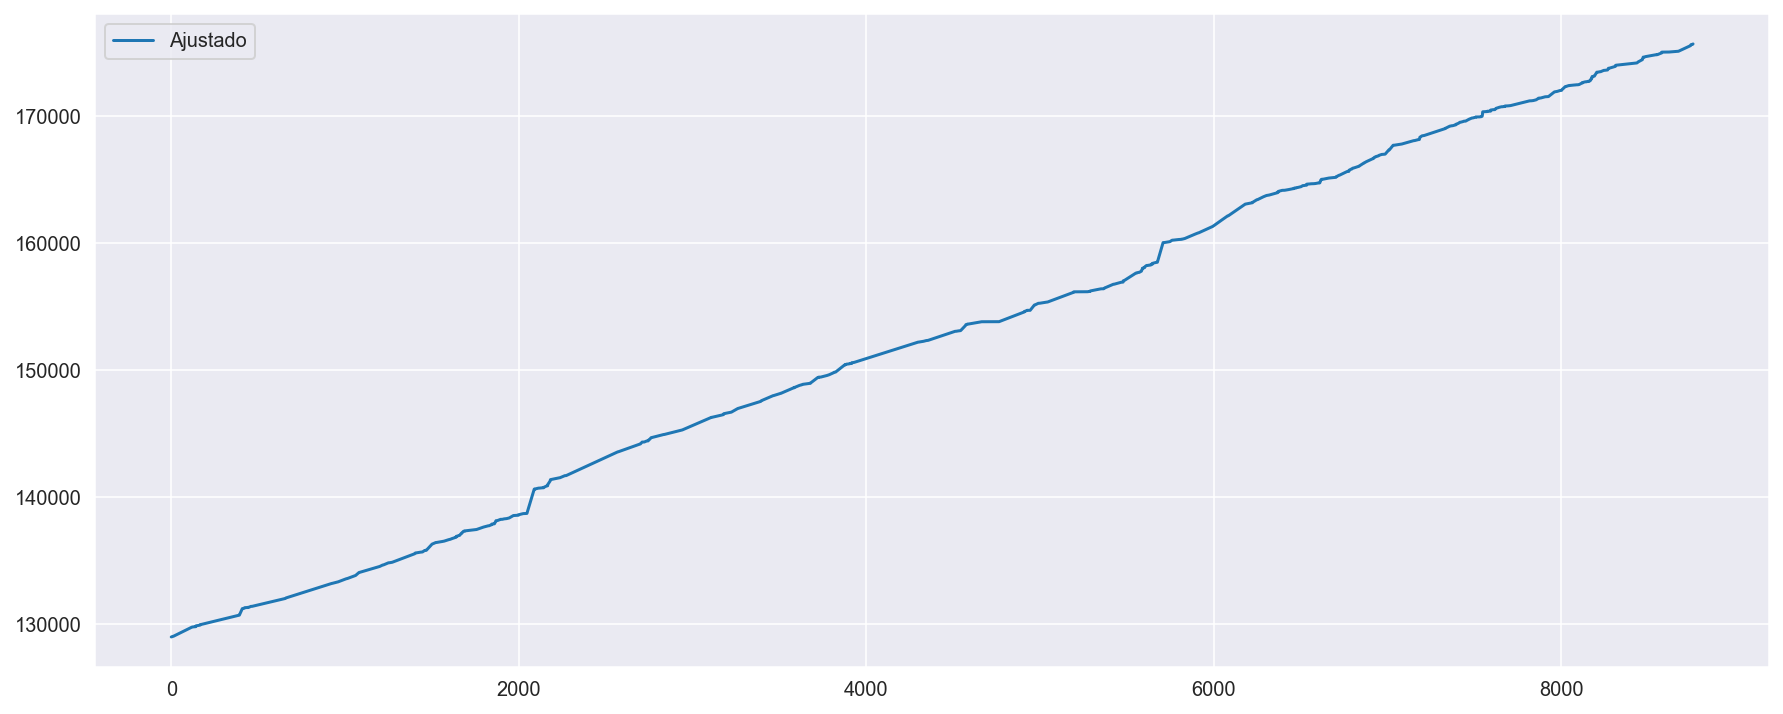

72


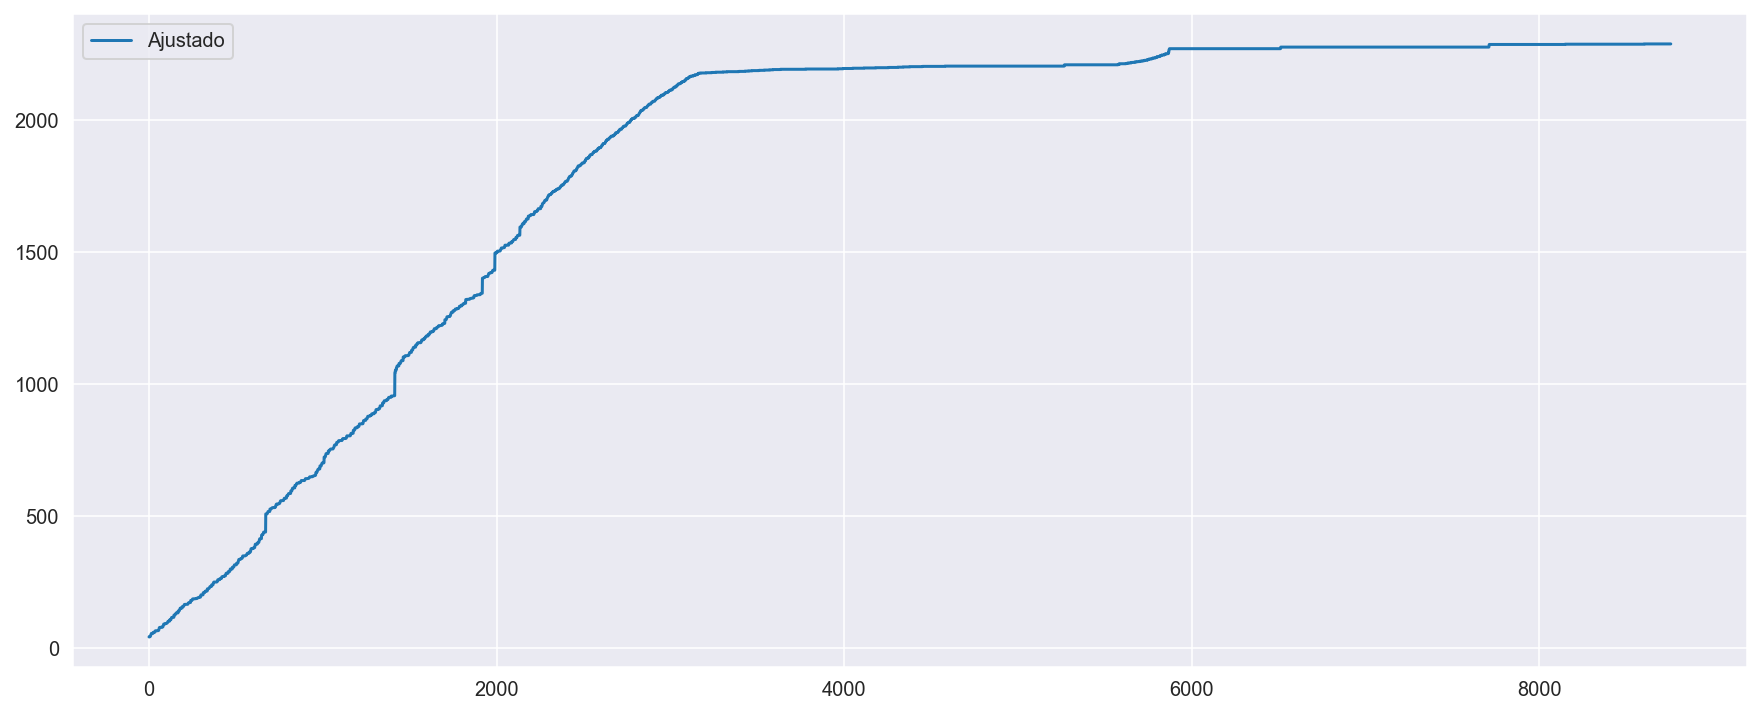

In [3]:
# Para cada índice
for i in [11, 26, 37, 72]:
    print(i)
    df_temp = df.loc[i]
    
    plt.plot(df.loc[i].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Ajustado")
    plt.legend()
    plt.show()

## Correlación de variables

Una vez que hemos enriquecido nuestros datos en el script de predicción, habiendo creado `Modelar_Procesado_DEF.csv`, vamos a comprobar la correlación entre las variables:

In [4]:
df = df.drop(['SAMPLETIME'], axis=1)

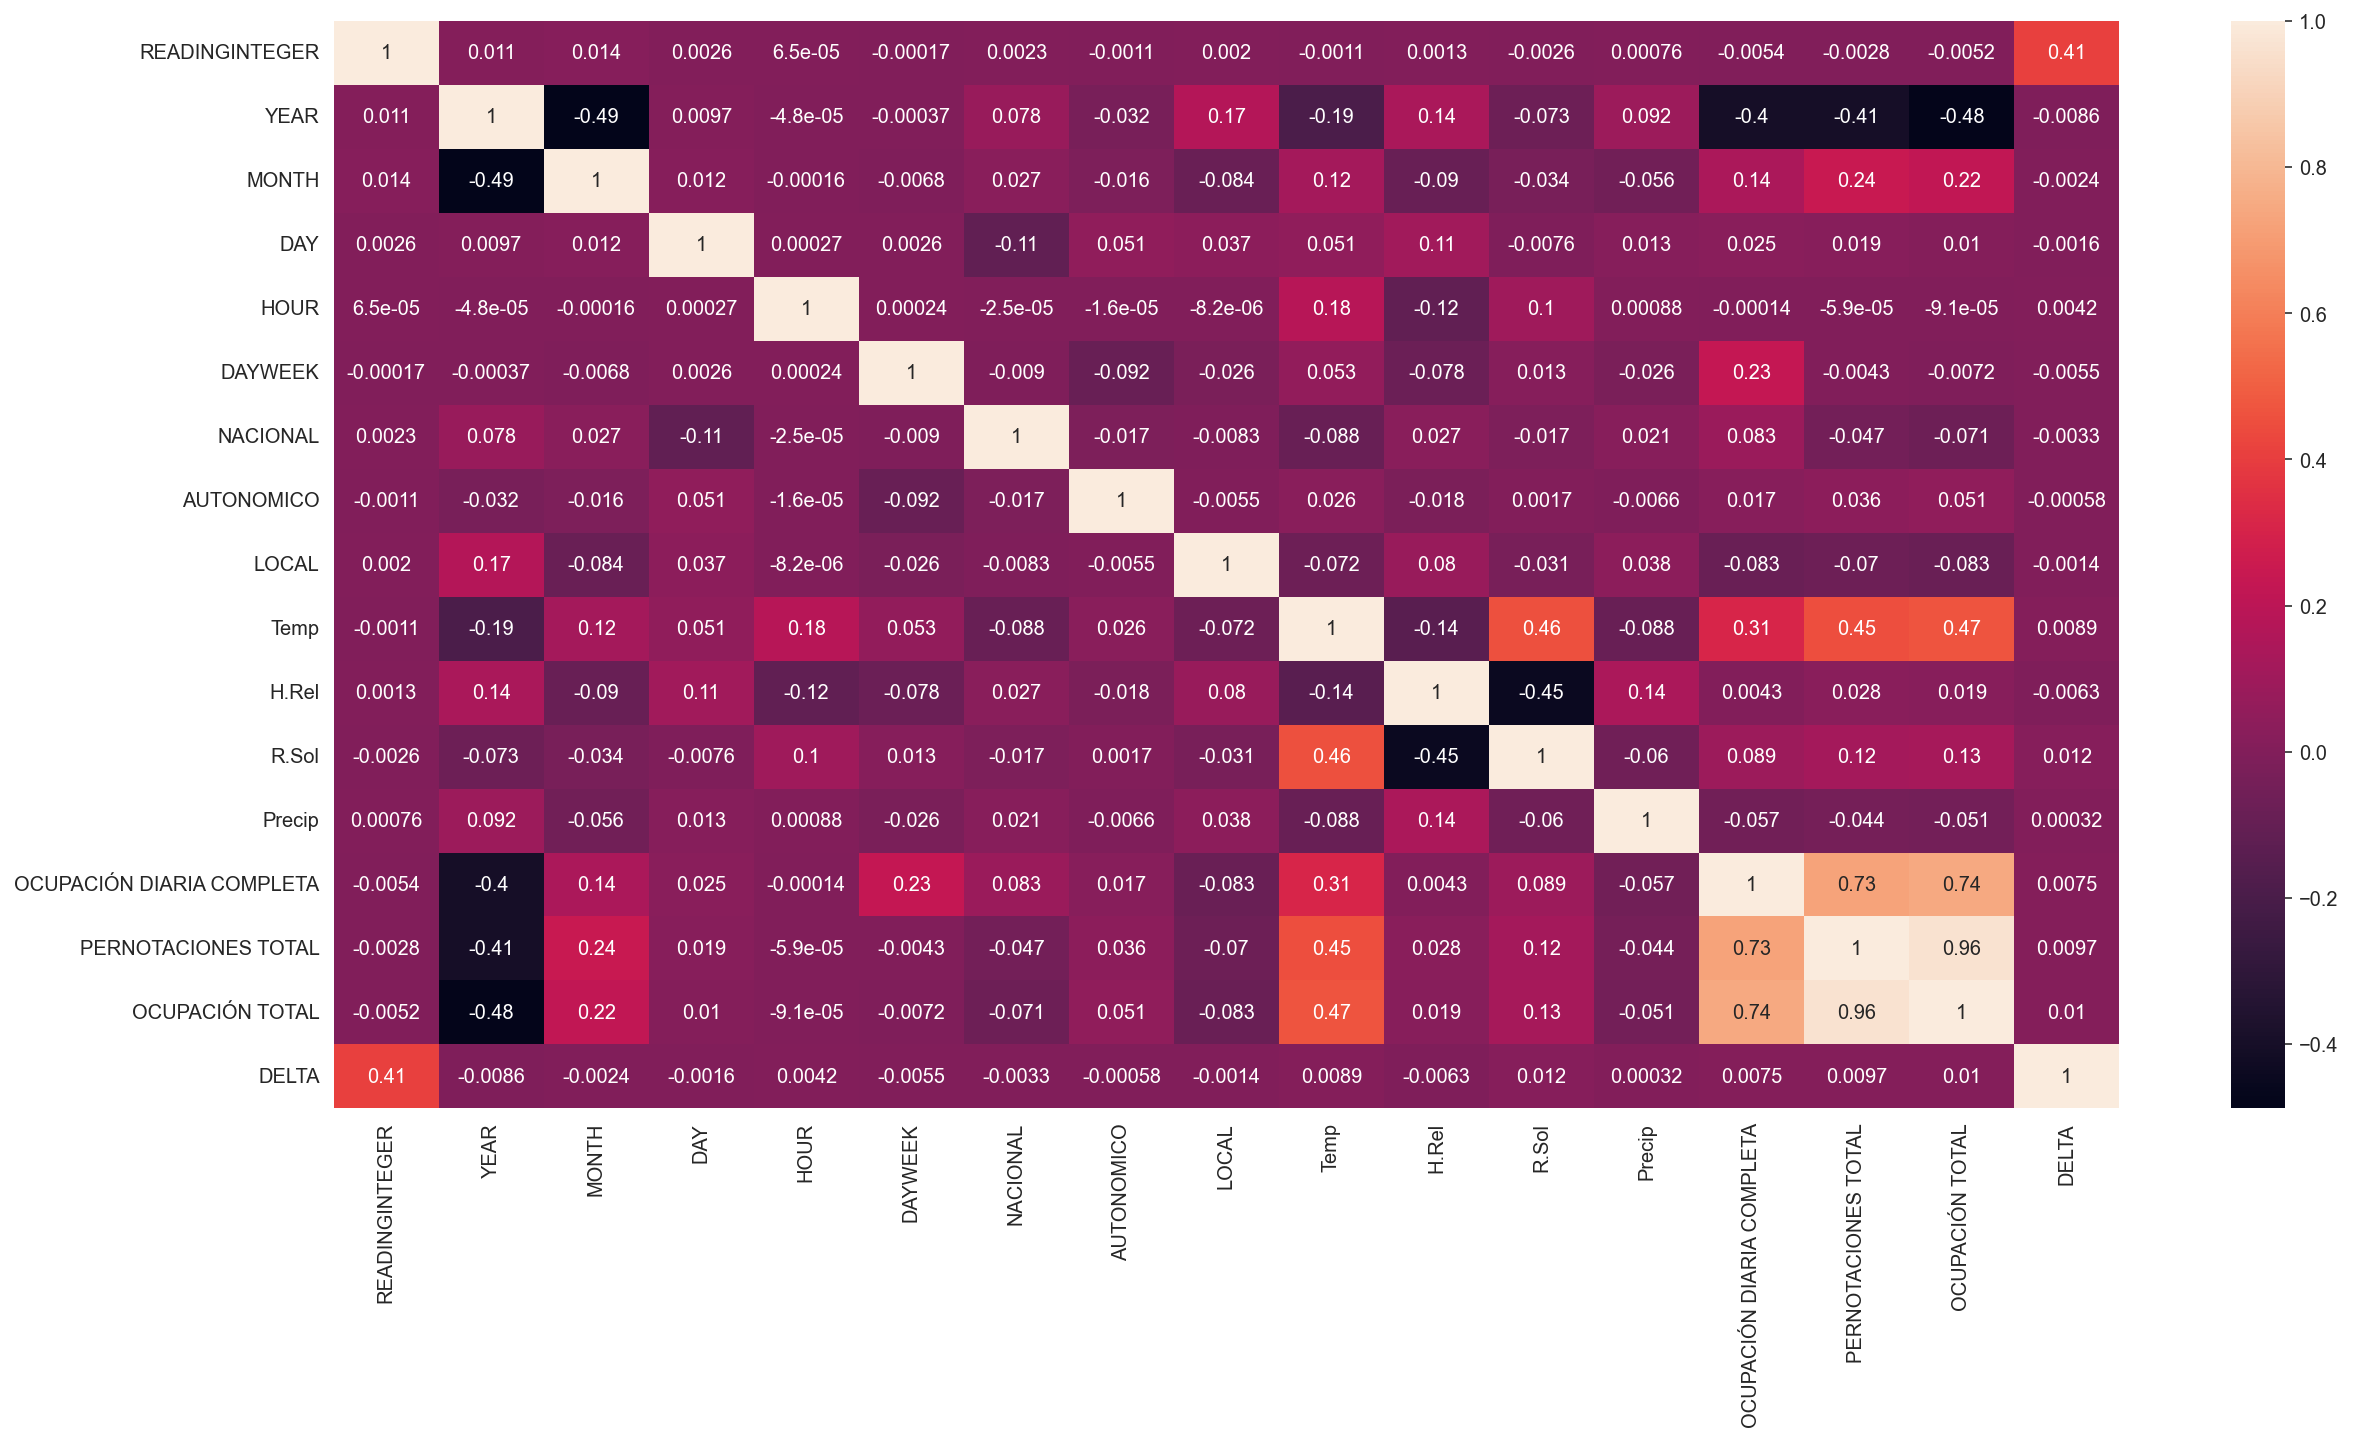

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.show()

Podemos ver cómo ni para `DELTA` ni para `READINGINTEGER` existe una gran correlación con ninguna de las variables. Podemos pensar que las variables que hemos añadido no serán de gran utilidad, pero si vemos que su correlación es similar a la que pueden tener el día, el mes o la hora, variables que deberían ser importantes en este problema, no hay motivo para quitarlas

## Estacionalidad

Vamos a comprobar si nuestra nueva `DELTA` creada es estacional o no

In [134]:
df = pd.read_csv('data/Modelar_UH2022_DEF.csv', index_col='ID', parse_dates=True)
df['SAMPLETIME'] = pd.to_datetime(df['SAMPLETIME'])
df = df.reset_index(drop=False)

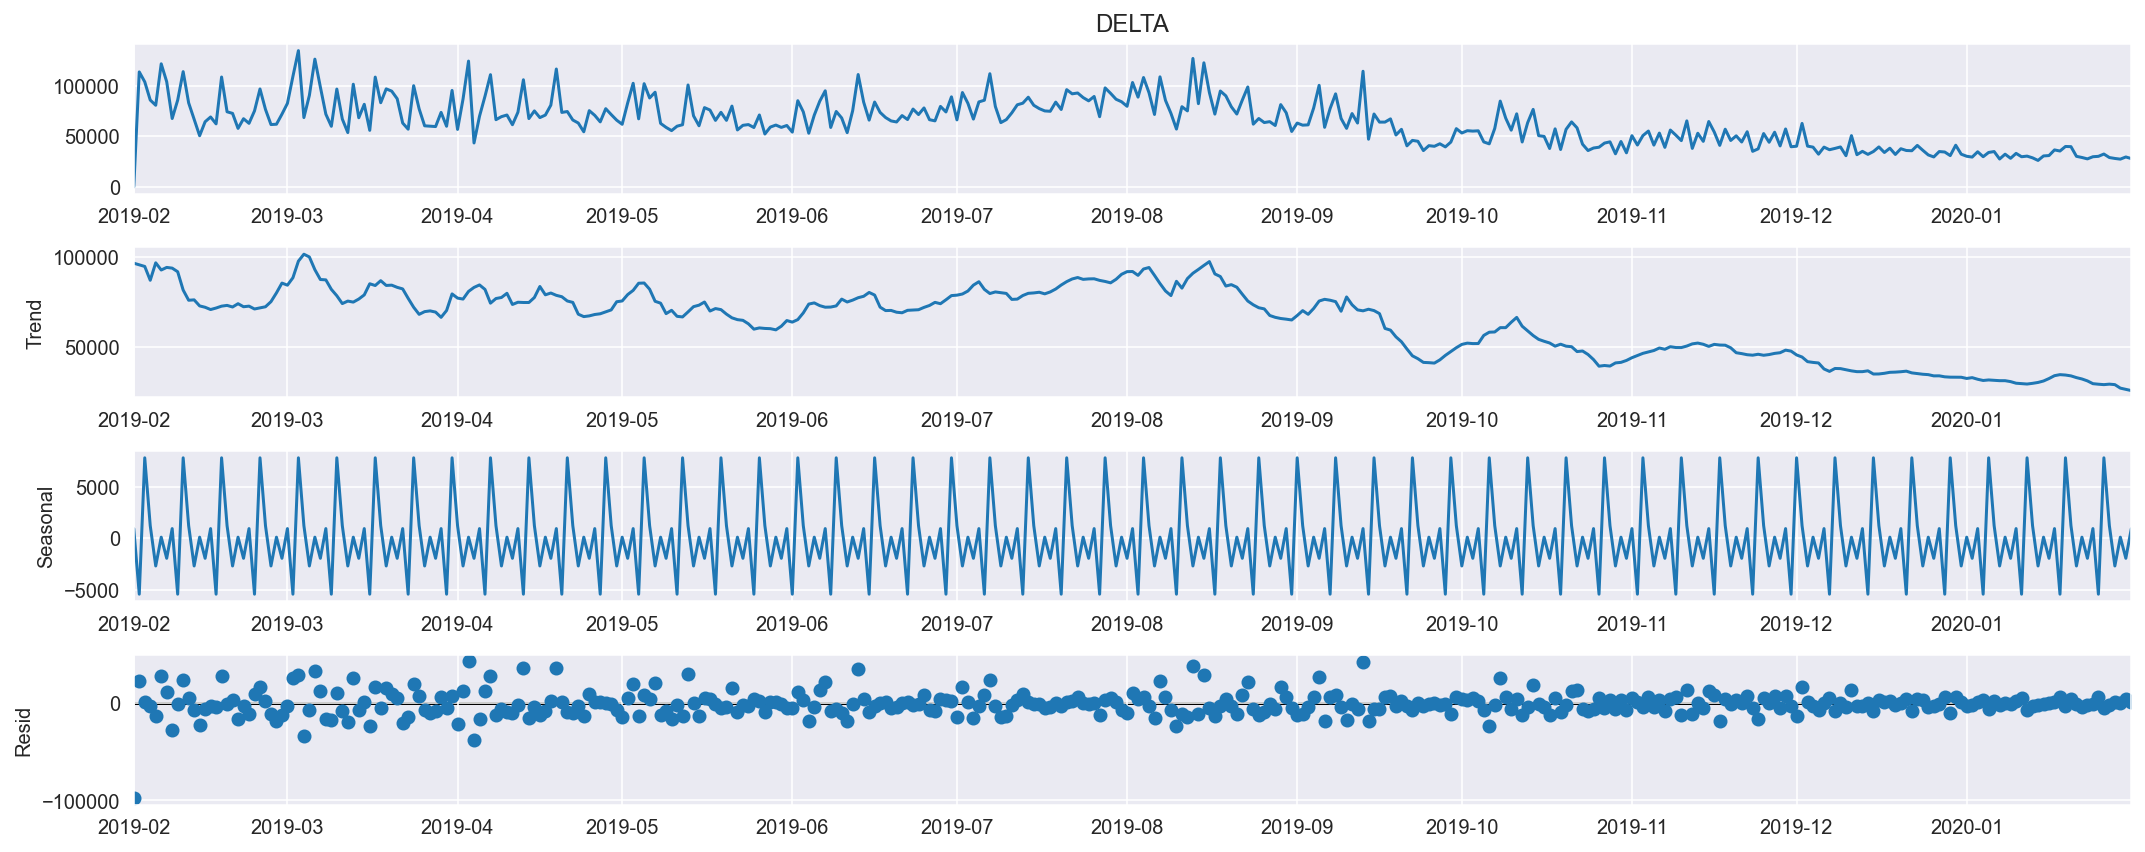

In [137]:
df_dia = df.groupby('SAMPLETIME').sum().asfreq('D')
ts_decompose = seasonal_decompose(df_dia.DELTA, extrapolate_trend='freq')
ts_decompose.plot()
plt.show()

Parece que sí es algo estacional con respecto a los días de la semana. Además, también podemos ver cómo la tendencia cambia despúes del verano, pasando de moverse entre los valores `6000` y `10000`, a hacerlo en menos de `5000`. El problema es que no podemos saber realmente si esto se debe a que los datos son así, a que hemos introducido valores para los últimos meses demasiado bajos con los imputadores, o a que intoducimos valores demaisado altos en los primeros meses. Lo que sí que parece es que la serie en los últimos meses es más uniforme, sin tantos altibajos.

Si comprobamos los consumos por días, vemos cómo los lunes y viernes es cuando más altos son, mientras que los sábados y domingos es cuando menos agua se gasta:

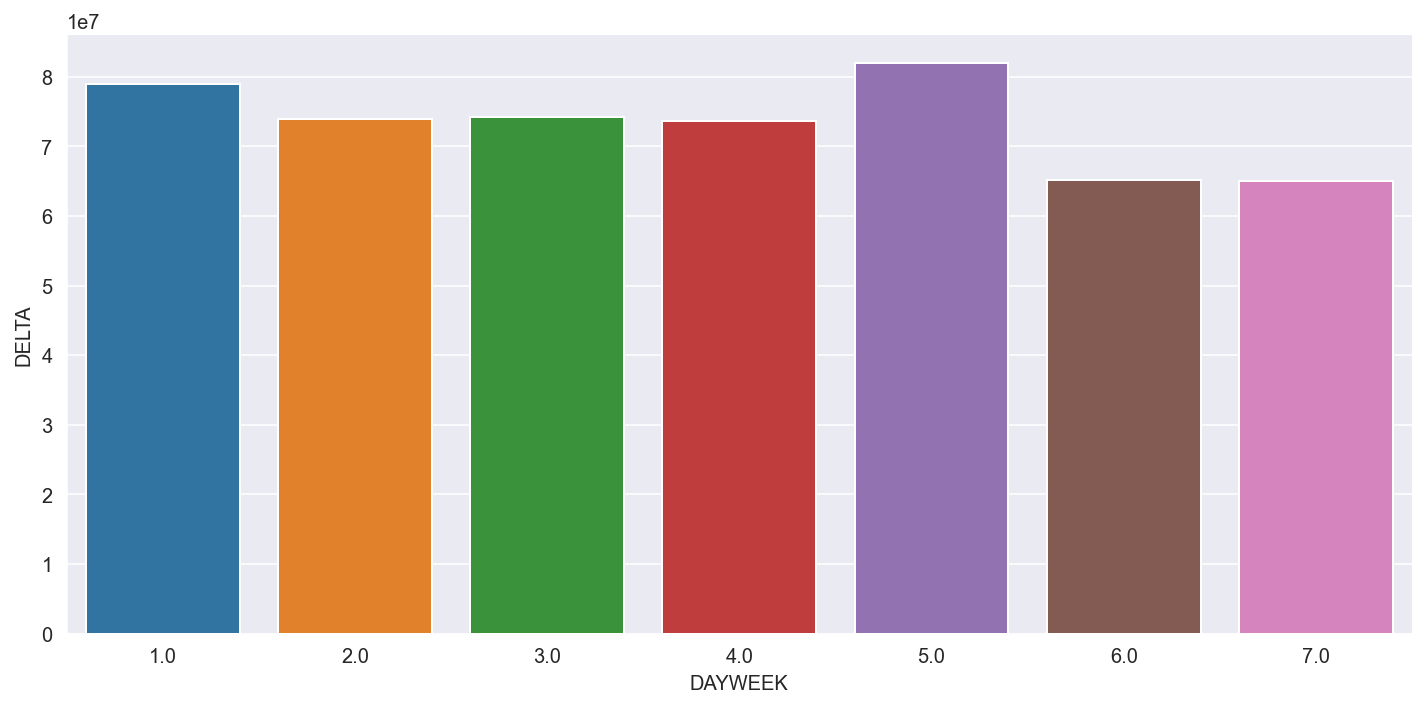

In [146]:
df_dia = df.groupby('DAYWEEK').sum().reset_index()
sns.catplot(data=df_dia, x='DAYWEEK', y='DELTA', kind='bar', aspect=2)

Mientras, si agrupamos por meses podemos ver lo mismo que hemos comentado anteriormente: los meses en los que hay más gasto son los de verano, y a partir de septiembre el gasto de agua baja bastante (hay que tener en cuenta que el mes de enero que aparece es el de 2020, por lo que realmente debería situarse después de diciembre y no al principio):

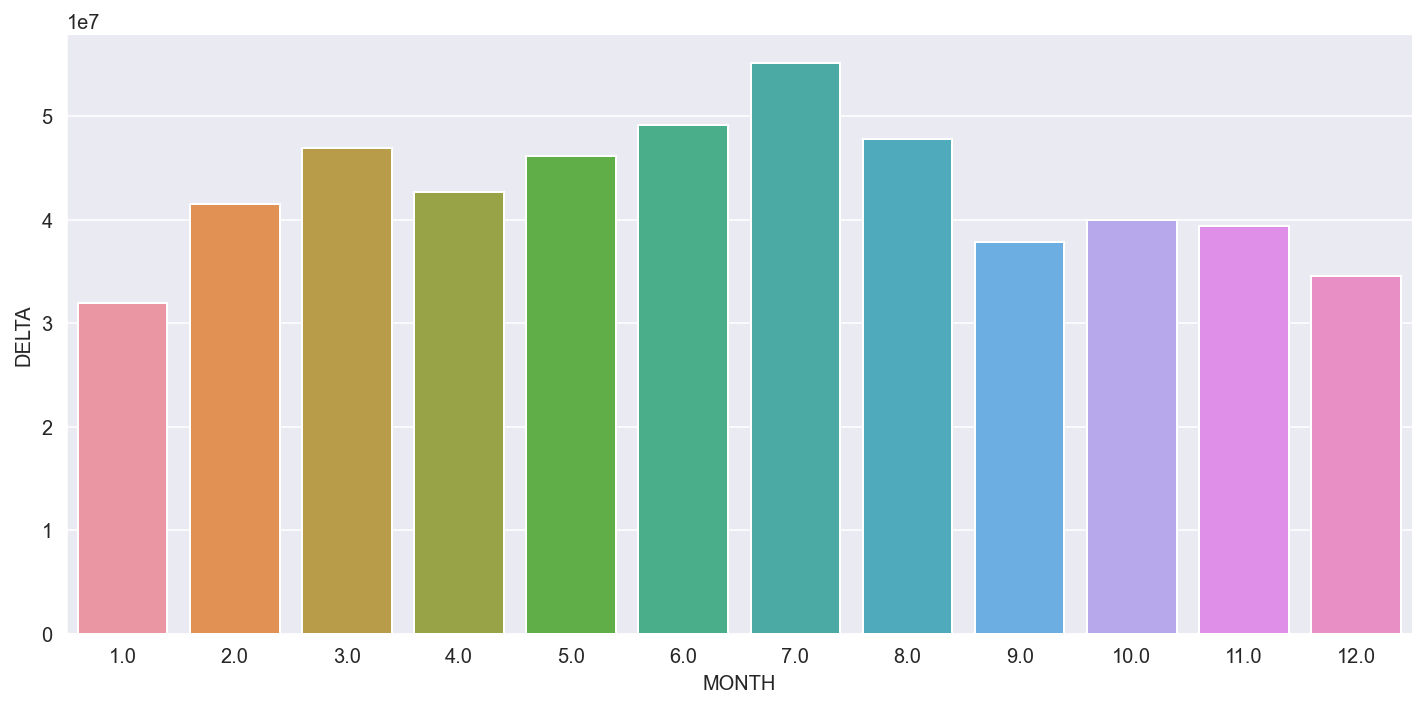

In [159]:
df_dia = df.groupby('MONTH').sum().reset_index()
sns.catplot(data=df_dia, x='MONTH', y='DELTA', kind='bar', aspect=2)

Y si realizamos una agrupación por horas, podemos ver cómo los mayores consumos se dan por la mañana, seguidos de los consumos por la tarde. Los más bajos se dan por la noche (aunque a las 12 de la noche hay un gran repunte, seguramente porque esa hora está recogiendo consumos que no le corresponden de las 11 o la 1):

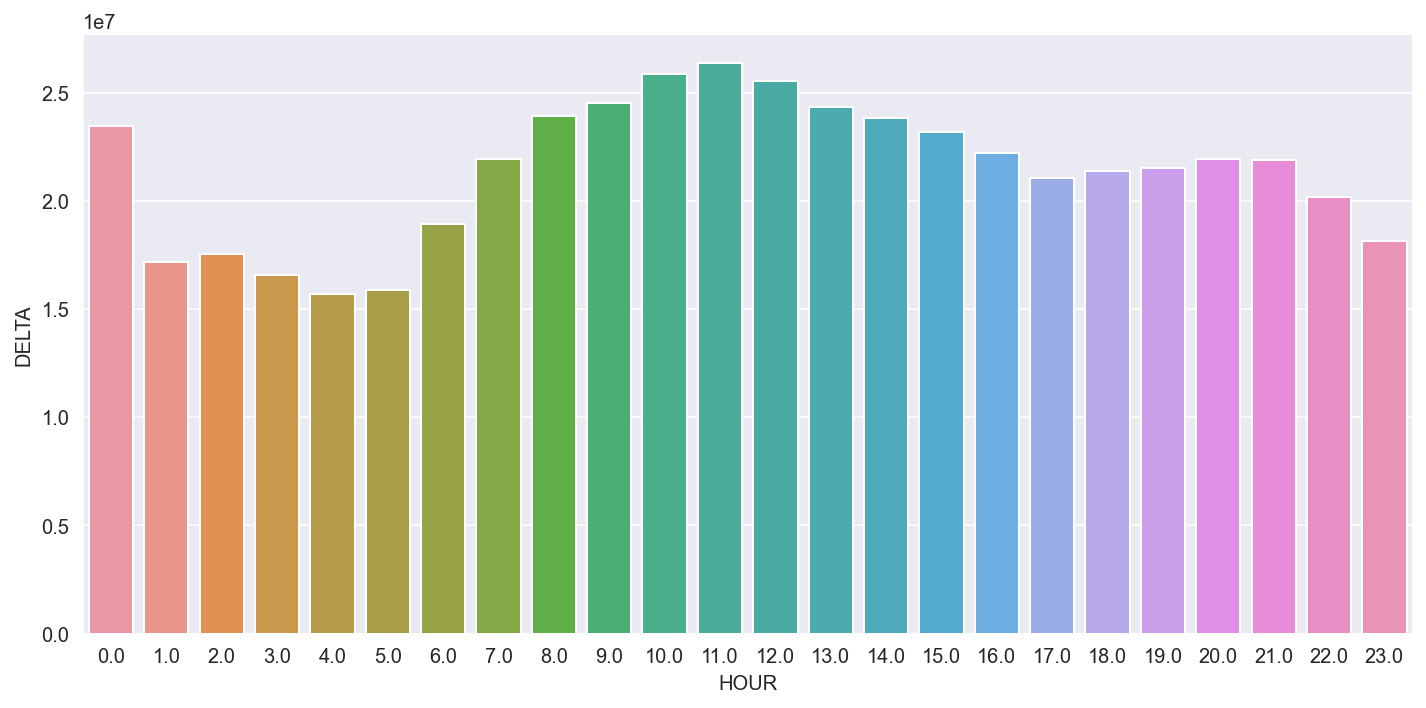

In [152]:
df_dia = df.groupby('HOUR').sum().reset_index()
sns.catplot(data=df_dia, x='HOUR', y='DELTA', kind='bar', aspect=2)